# Investigate a potential blob bump on mainnet
See .env.example to set the environment variables.

In [2]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn > /dev/null 2>&1

In [3]:
import dotenv
import os
from datetime import datetime

dotenv.load_dotenv()

# Load and display config
start_date = os.getenv('START_DATE_TIME')
if not start_date:
    raise ValueError("START_DATE_TIME environment variable is required")

end_date = os.getenv('END_DATE_TIME')
if not end_date:
    end_date = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

network = os.getenv('NETWORK')

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

# Convert start and end dates to datetime objects
try:
    start_dt = datetime.fromisoformat(start_date.replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid start date format. Date must be in ISO format. Error: {str(e)}")

try:
    if isinstance(end_date, datetime):
        end_dt = end_date
    else:
        end_dt = datetime.fromisoformat(str(end_date).replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid end date format. Date must be in ISO format. Error: {str(e)}")

# Calculate the difference in hours
hours = (end_dt - start_dt).total_seconds() / 3600

print(f"hours: {hours}")


start_date: 2024-10-04T22:00:00Z
end_date: 2024-11-22T15:32:50Z
hours: 1169.5472222222222


In [4]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine

engine = create_engine(db_url)

connection = engine.connect()

In [5]:
from sqlalchemy import text

query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        extract(meta_client_name, '.*/([^/]+)/hashed-[0-9a-f]+') AS user,
        meta_network_name,
        uniqExact(meta_client_name) AS total
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND user != ''
    GROUP BY time, user, meta_network_name
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
users = result.fetchall()

if len(users) == 0:
    raise ValueError("No users found for the given time range")

print(f"Found {len(users)} users for the given time range")




Found 510 users for the given time range


<Figure size 2100x1500 with 0 Axes>

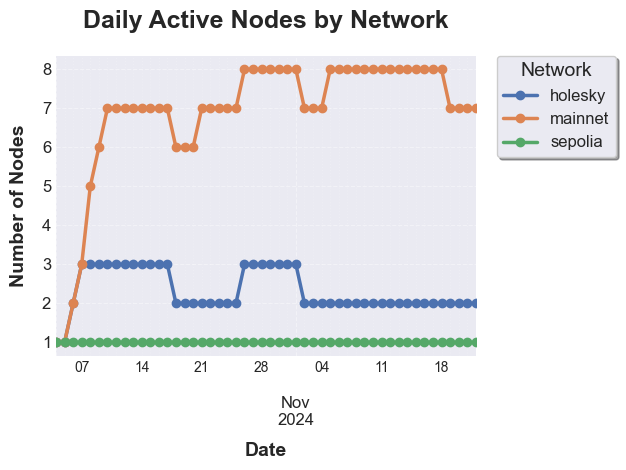

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set modern style and color palette
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")

# Convert results to DataFrame and prepare data
df = pd.DataFrame(users, columns=['time', 'user', 'network', 'total'])
df['time'] = pd.to_datetime(df['time'])

# Create high resolution figure
plt.figure(figsize=(14, 10), dpi=150)

# Plot data with enhanced styling
pivot_df = df.groupby(['time', 'network'])['user'].nunique().unstack(fill_value=0)
ax = pivot_df.plot(kind='line', marker='o', markersize=6, linewidth=2.5)

# Add sophisticated styling
plt.title('Daily Active Nodes by Network', pad=20, fontsize=18, fontweight='bold', 
         fontfamily='sans-serif')
plt.xlabel('Date', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Nodes', fontsize=14, fontweight='bold', labelpad=10)

# Style the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=12)

# Enhance legend with custom styling
plt.legend(title='Network', 
          title_fontsize=14,
          fontsize=12,
          bbox_to_anchor=(1.05, 1),
          loc='upper left',
          borderaxespad=0,
          frameon=True,
          fancybox=True,
          shadow=True)

# Add refined grid
plt.grid(True, linestyle='--', alpha=0.4, which='major')
plt.grid(True, linestyle=':', alpha=0.2, which='minor')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [7]:
from sqlalchemy import text

query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        meta_consensus_implementation as client,
        meta_network_name,
        count(distinct meta_client_name) AS total
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_network_name = 'mainnet'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
    GROUP BY time, client, meta_network_name
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
clients = result.fetchall()

if len(clients) == 0:
    raise ValueError("No clients found for the given time range")

print(f"Found {len(clients)} clients for the given time range")




Found 196 clients for the given time range


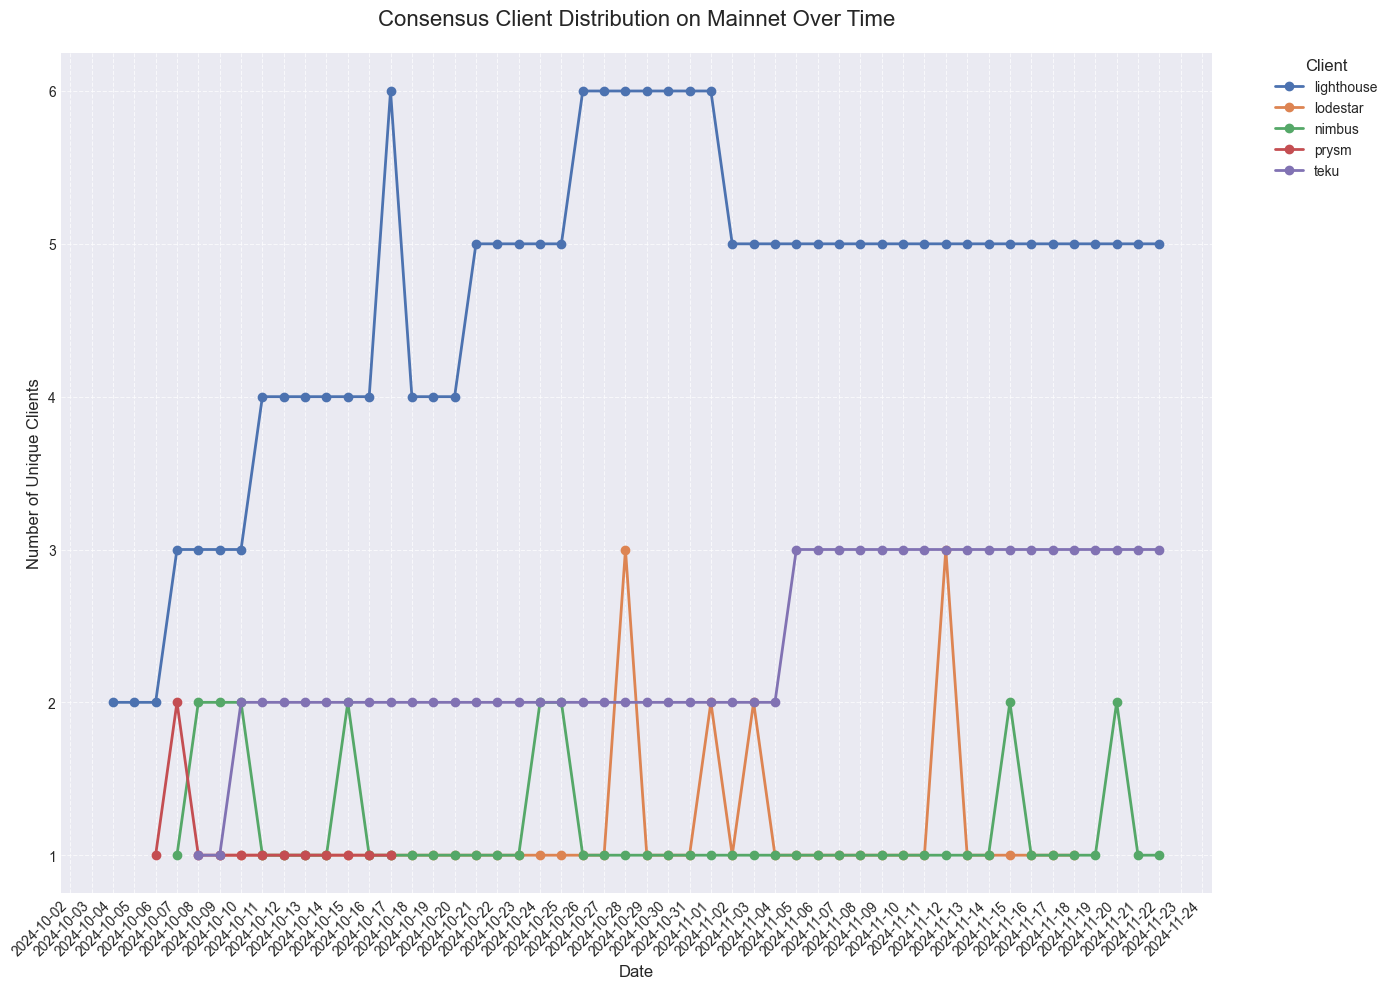

In [8]:
from matplotlib.dates import DateFormatter, DayLocator

# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(clients, columns=['time', 'client', 'network', 'total'])

# Sort by time to ensure proper line plotting
df = df.sort_values('time')

# Create a figure with a specific size
plt.figure(figsize=(14, 10))

# Create a line plot for each client
for client in sorted(df['client'].unique()):
    client_data = df[df['client'] == client].copy()
    # Ensure data is sorted chronologically
    client_data = client_data.sort_values('time')
    plt.plot(client_data['time'], client_data['total'], marker='o', label=client, linewidth=2, markersize=6)

# Customize the plot
plt.title('Consensus Client Distribution on Mainnet Over Time', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)

# Format x-axis with appropriate time intervals
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(DayLocator())
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(title='Client', 
          title_fontsize=12,
          fontsize=10,
          bbox_to_anchor=(1.05, 1), 
          loc='upper left',
          borderaxespad=0)

# Customize grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
from sqlalchemy import text

query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        meta_client_geo_country as country,
        meta_network_name,
        count(distinct meta_client_name) AS total
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_network_name = 'mainnet'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
    GROUP BY time, country, meta_network_name
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
countries = result.fetchall()

if len(clients) == 0:
    raise ValueError("No clients found for the given time range")

print(f"Found {len(countries)} countries for the given time range")




Found 325 countries for the given time range


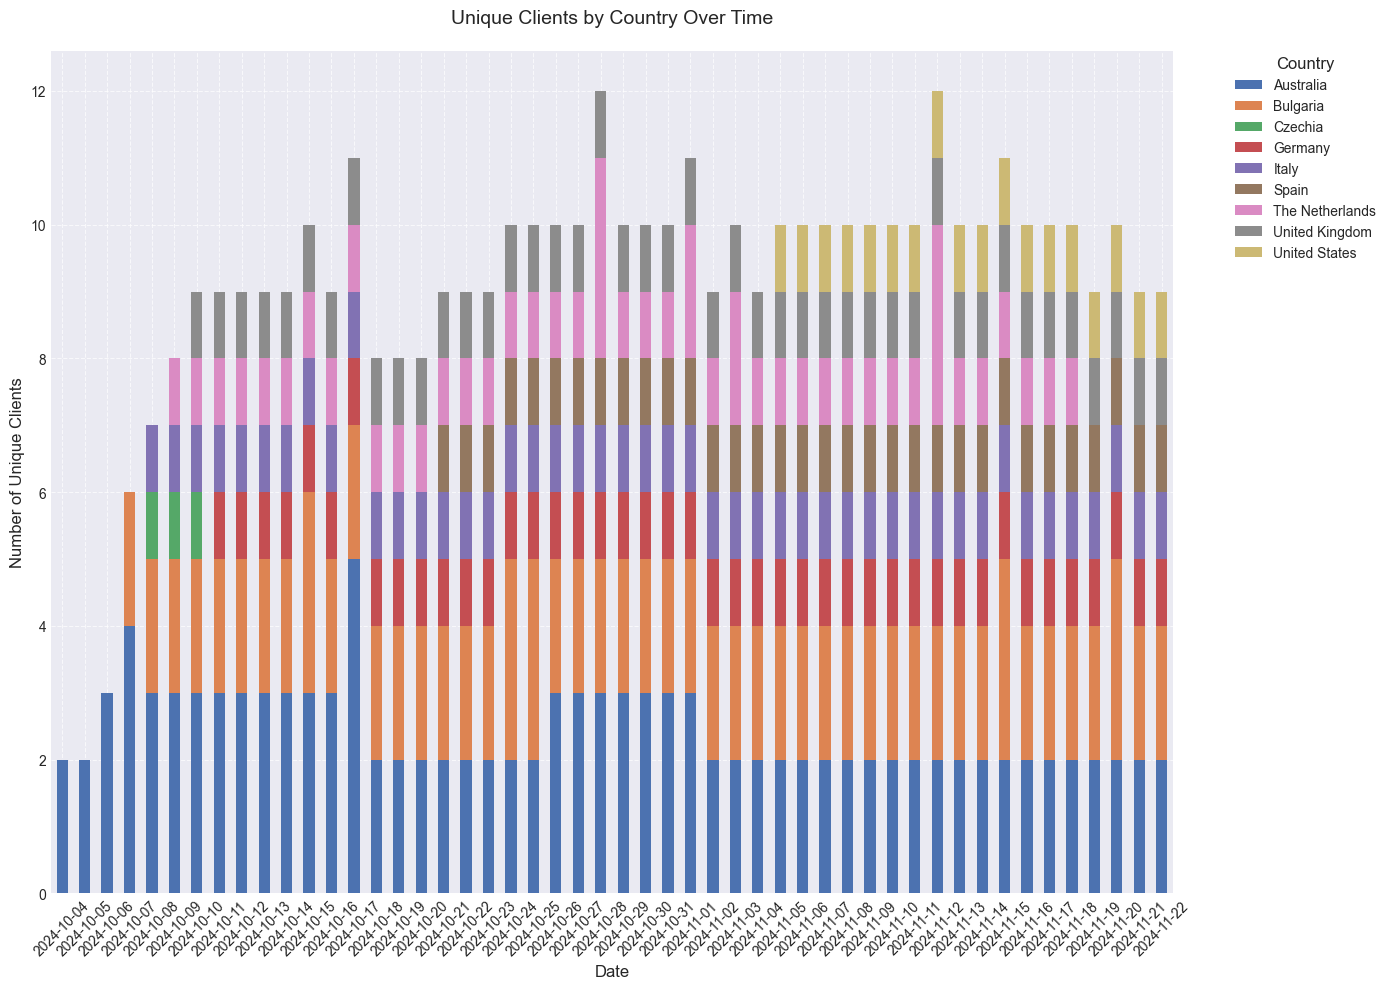

In [10]:
# Convert the results to a pandas DataFrame
df = pd.DataFrame(countries, columns=['time', 'country', 'meta_network_name', 'total'])

# Create the plot
plt.figure(figsize=(14, 10))

# Plot stacked bars for each country
df_pivot = df.pivot(index='time', columns='country', values='total')
df_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

# Customize the plot
plt.title('Unique Clients by Country Over Time', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Country',
          title_fontsize=12,
          fontsize=10, 
          bbox_to_anchor=(1.05, 1),
          loc='upper left',
          borderaxespad=0)

# Customize grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
from sqlalchemy import text

query = text("""
    SELECT
        meta_client_geo_country as countries
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_network_name = 'mainnet'
    GROUP BY countries
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
distinct_countries = result.fetchall()

if len(distinct_countries) == 0:
    raise ValueError("No distinct countries found for the given time range")

print(f"Found {len(distinct_countries)} distinct countries for the given time range")


Found 9 distinct countries for the given time range


In [12]:

query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as arrival_time,
        meta_client_geo_country as country
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, country, slot
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
country_arrival_times = result.fetchall()

if len(country_arrival_times) == 0:
    raise ValueError("No country arrival times found for the given time range")

print(f"Found {len(country_arrival_times)} country arrival times for the given time range")


Found 2235681 country arrival times for the given time range


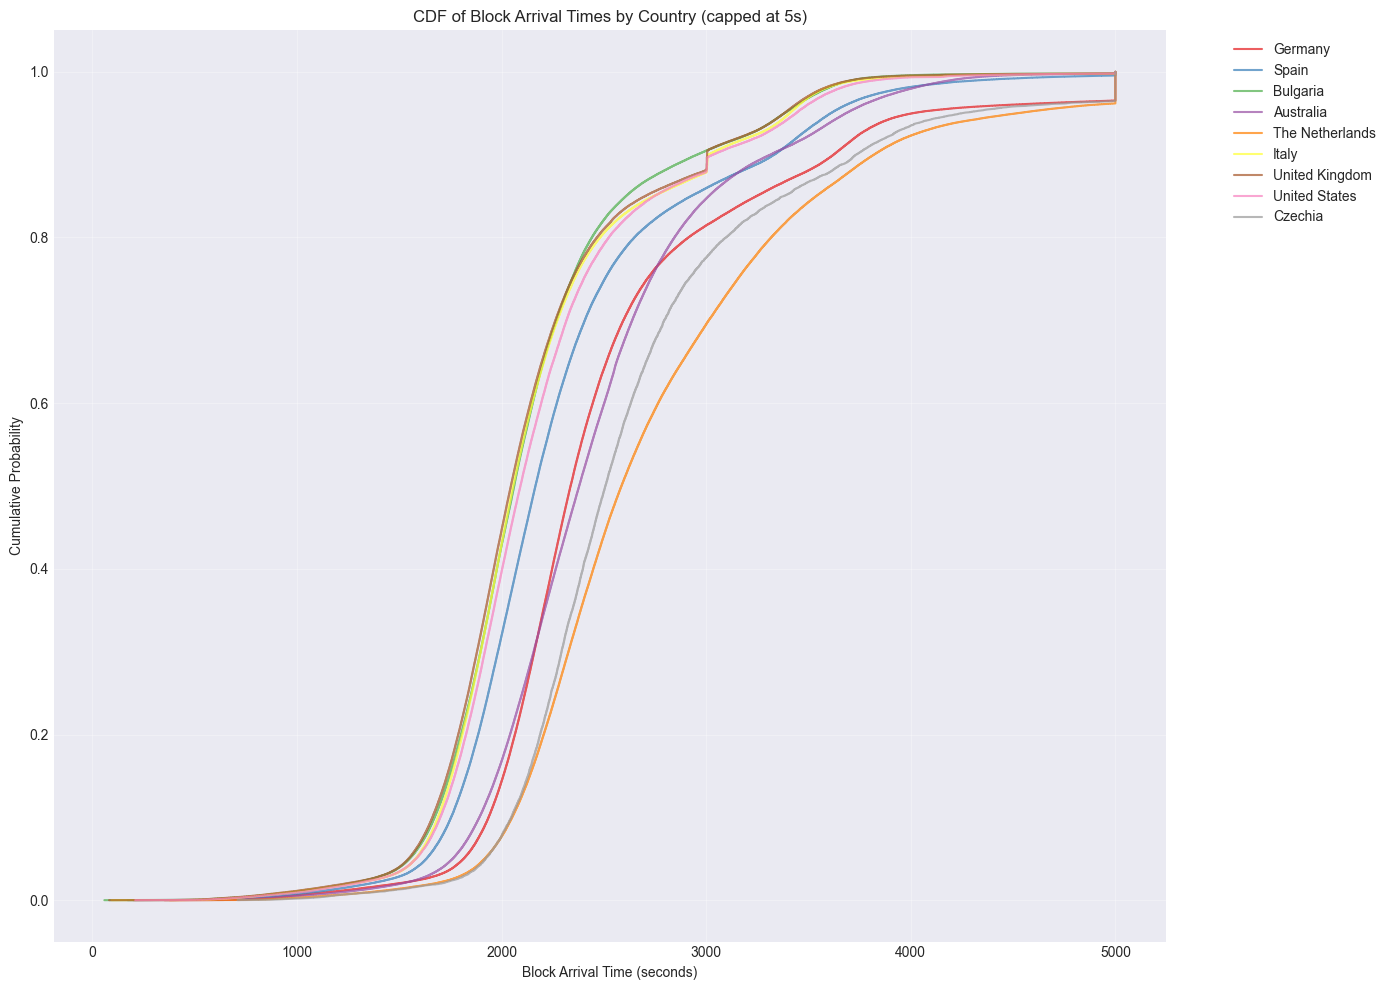

In [13]:
# Import numpy
import numpy as np

# Convert results to pandas DataFrame and use the country_arrival_times data
df = pd.DataFrame(country_arrival_times)

# Create a figure with a larger size
plt.figure(figsize=(14, 10))

# Define a distinct color palette
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', 
          '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62', '#8da0cb',
          '#e78ac3', '#a6d854', '#ffd92f']

# Calculate and plot CDF for each country
for i, country in enumerate(df['country'].unique()):
    # Get arrival times for this country and cap at 5 seconds
    country_data = df[df['country'] == country]['arrival_time'].clip(upper=5000)
    
    # Sort the data
    sorted_data = np.sort(country_data)
    
    # Calculate cumulative probabilities
    cumulative_prob = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Plot CDF with distinct color
    plt.plot(sorted_data, cumulative_prob, label=country, alpha=0.7, 
             color=colors[i % len(colors)])

plt.grid(True, alpha=0.3)
plt.xlabel('Block Arrival Time (seconds)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Block Arrival Times by Country (capped at 5s)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()


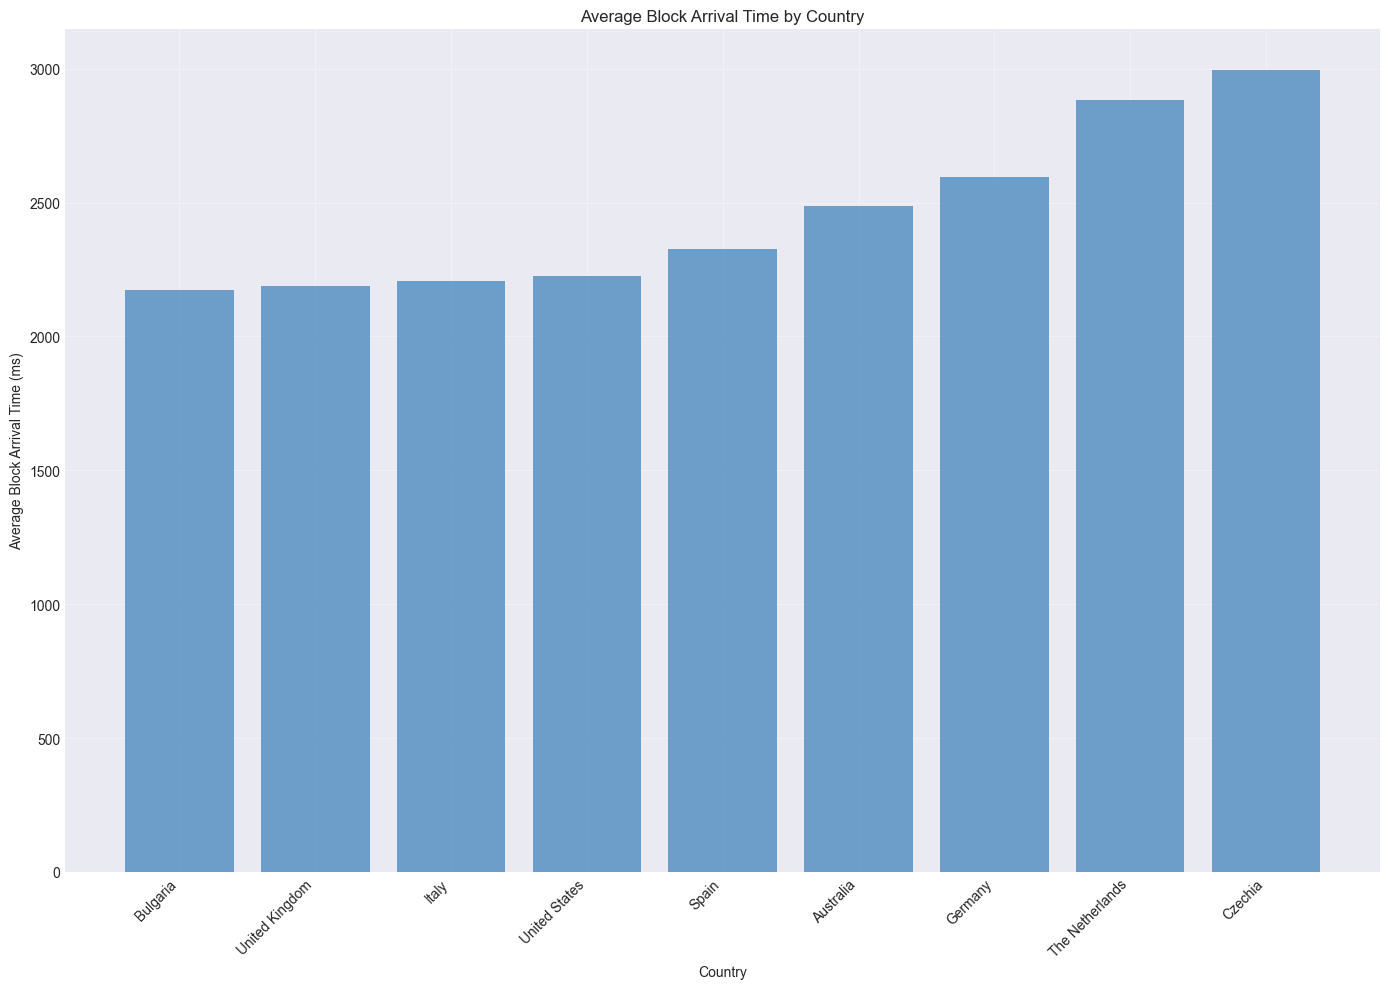

In [14]:
# Convert results to pandas DataFrame
df = pd.DataFrame(country_arrival_times)

# Create a figure with a larger size
plt.figure(figsize=(14, 10))

# Calculate average arrival time per country
avg_arrival_times = df.groupby('country')['arrival_time'].mean().sort_values(ascending=True)

# Create bar plot
plt.bar(range(len(avg_arrival_times)), avg_arrival_times.values, color='#377eb8', alpha=0.7)

# Customize the plot
plt.xticks(range(len(avg_arrival_times)), avg_arrival_times.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.xlabel('Country')
plt.ylabel('Average Block Arrival Time (ms)')
plt.title('Average Block Arrival Time by Country')

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
# Query for block events
block_query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as block_arrival_time,
        meta_client_name as client
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, client, slot
""")

# Query for head events
head_query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as head_arrival_time,
        meta_client_name as client
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, client, slot
""")

# Execute both queries
block_result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
head_result = connection.execute(head_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})

# Convert results to DataFrames
block_df = pd.DataFrame(block_result.fetchall(), columns=['time', 'block_arrival_time', 'client'])
head_df = pd.DataFrame(head_result.fetchall(), columns=['time', 'head_arrival_time', 'client'])

# Drop rows with missing client values
block_df = block_df.dropna(subset=['client'])
head_df = head_df.dropna(subset=['client'])

# Merge the DataFrames
merged_df = pd.merge(block_df, head_df, on=['time', 'client'])

# Calculate the difference between head and block arrival times
merged_df['arrival_diff'] = merged_df['head_arrival_time'] - merged_df['block_arrival_time']

if len(merged_df) == 0:
    raise ValueError("No arrival times found for the given time range")

print(f"Found {len(merged_df)} arrival time differences for the given time range")


Found 3012163 arrival time differences for the given time range


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/165973522.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


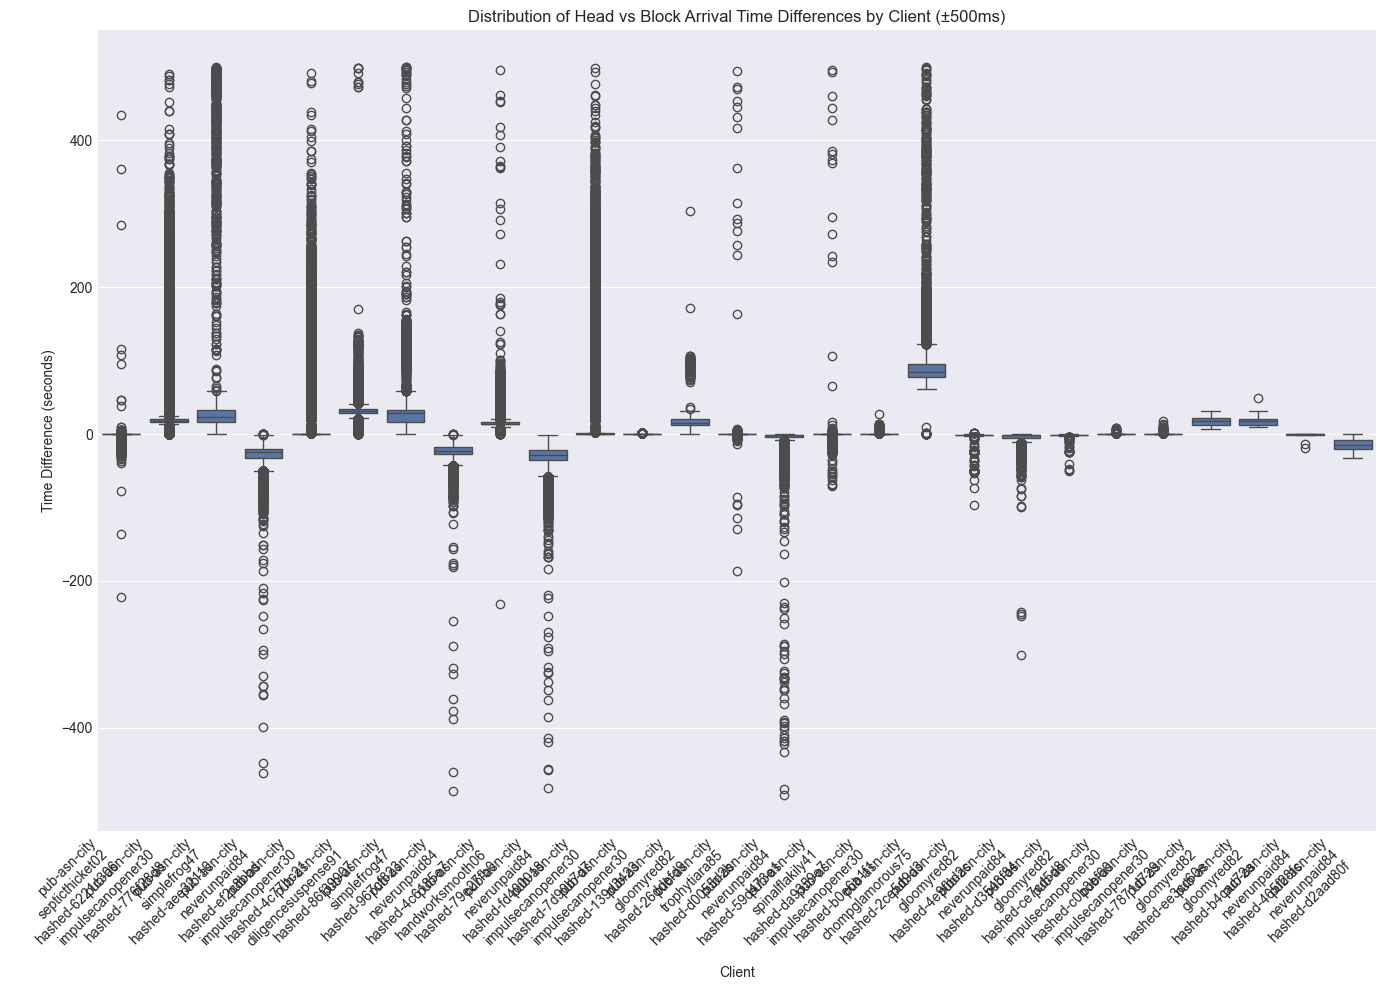

In [16]:
# Filter data
filtered_df = merged_df[(merged_df['arrival_diff'] <= 500) & (merged_df['arrival_diff'] >= -500) & (merged_df['client'] != '')]

# Create a figure with a larger size
plt.figure(figsize=(14, 10))

# Create box plot with client names split on multiple lines
sns.boxplot(data=filtered_df, x='client', y='arrival_diff')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Replace / with newlines in x-axis labels
labels = [label.get_text().replace('/', '\n') for label in plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(labels)

# Customize the plot
plt.title('Distribution of Head vs Block Arrival Time Differences by Client (±500ms)')
plt.xlabel('Client')
plt.ylabel('Time Difference (seconds)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
# Query for block events
block_query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as block_arrival_time,
        meta_consensus_implementation as client
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, client, slot
""")

# Query for head events
head_query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as head_arrival_time,
        meta_consensus_implementation as client
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, client, slot
""")

# Execute both queries
block_result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
head_result = connection.execute(head_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})

# Convert results to DataFrames
block_df = pd.DataFrame(block_result.fetchall(), columns=['time', 'block_arrival_time', 'client'])
head_df = pd.DataFrame(head_result.fetchall(), columns=['time', 'head_arrival_time', 'client'])

# Drop rows with missing client values
block_df = block_df.dropna(subset=['client'])
head_df = head_df.dropna(subset=['client'])

# Merge the DataFrames
client_merged_df = pd.merge(block_df, head_df, on=['time', 'client'])

# Calculate the difference between head and block arrival times
client_merged_df['arrival_diff'] = client_merged_df['head_arrival_time'] - client_merged_df['block_arrival_time']

if len(client_merged_df) == 0:
    raise ValueError("No arrival times found for the given time range")

print(f"Found {len(client_merged_df)} arrival time differences for the given time range")



Found 1356036 arrival time differences for the given time range


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/3605591027.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


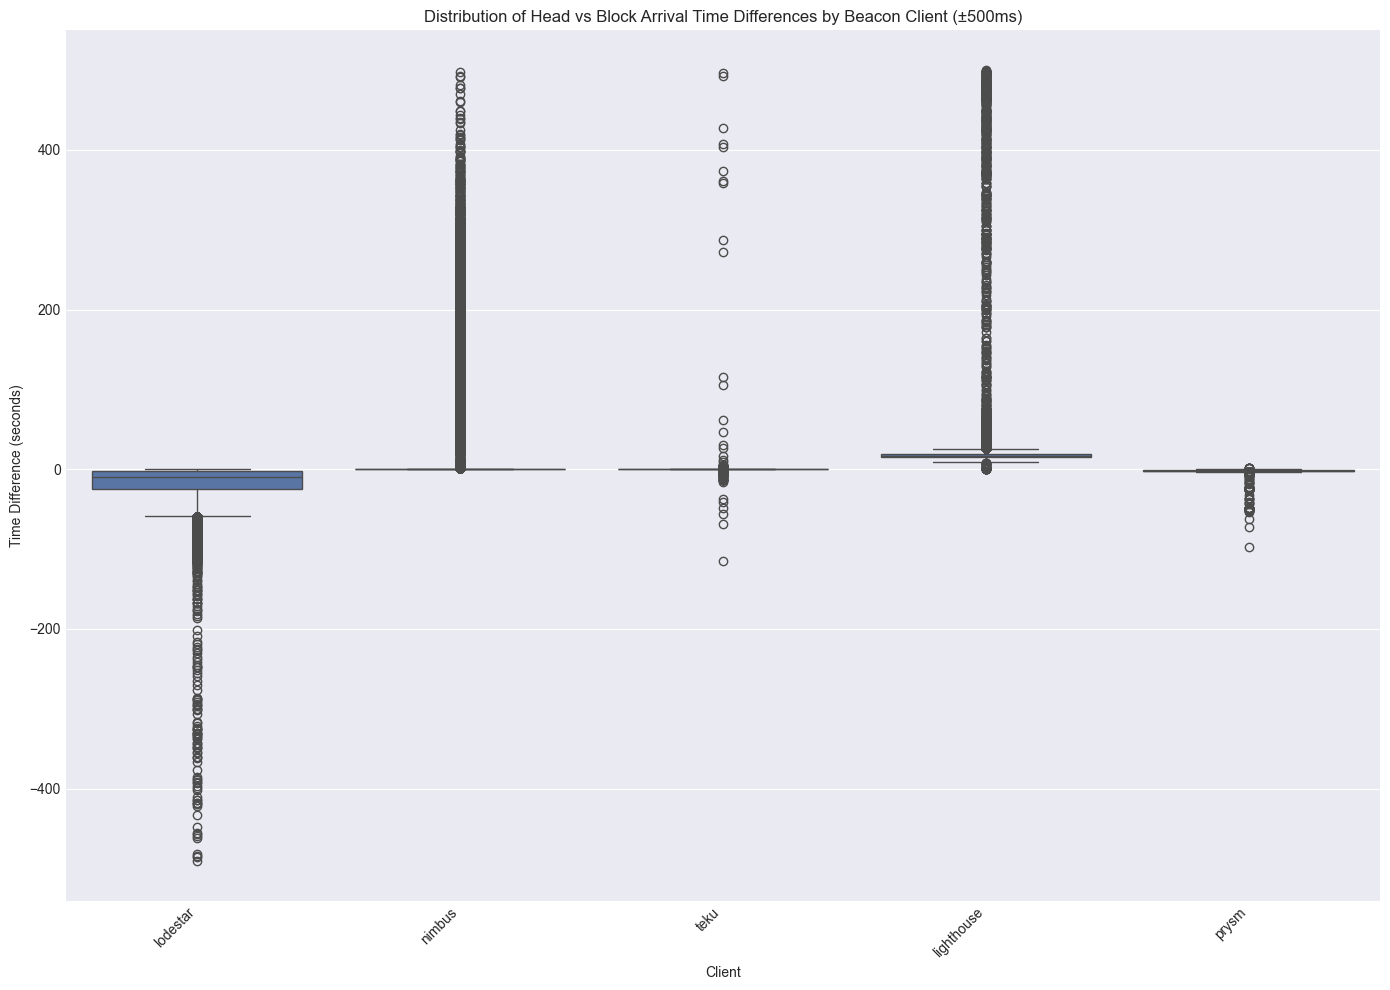

In [18]:
# Filter data
filtered_df = client_merged_df[(client_merged_df['arrival_diff'] <= 500) & (client_merged_df['arrival_diff'] >= -500) & (client_merged_df['client'] != '')]

# Create a figure with a larger size
plt.figure(figsize=(14, 10))

# Create box plot with client names split on multiple lines
sns.boxplot(data=filtered_df, x='client', y='arrival_diff')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Replace / with newlines in x-axis labels
labels = [label.get_text().replace('/', '\n') for label in plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(labels)

# Customize the plot
plt.title('Distribution of Head vs Block Arrival Time Differences by Beacon Client (±500ms)')
plt.xlabel('Client')
plt.ylabel('Time Difference (seconds)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
# Query for block events
block_query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        min(propagation_slot_start_diff) as min,
        max(propagation_slot_start_diff) as max,
        avg(propagation_slot_start_diff) as avg,
        quantile(0.95)(propagation_slot_start_diff) as p95,
        quantile(0.50)(propagation_slot_start_diff) as p50,
        quantile(0.05)(propagation_slot_start_diff) as p05

    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time
""")

result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
block_df = pd.DataFrame(result.fetchall(), columns=['time', 'min', 'max', 'avg', 'p95', 'p50', 'p05'])

print(block_df)

          time  min         max            avg      p95     p50      p05
0   2024-10-04  828        8186    2479.299916  3795.40  2344.0  1693.60
1   2024-10-05  537       22655    2475.873147  3703.45  2351.0  1751.00
2   2024-10-06  554        6519    2473.519136  3679.45  2369.0  1736.00
3   2024-10-07  445      217050    2470.441534  3701.00  2349.0  1660.00
4   2024-10-08  199  4294967224  103043.034926  3600.45  2227.0  1615.00
5   2024-10-09  384       75331    2424.673128  3653.00  2236.0  1601.55
6   2024-10-10  193  4294967218   78707.798960  3730.45  2258.0  1627.00
7   2024-10-11  269       16790    2356.890920  3615.45  2209.0  1591.55
8   2024-10-12  420       27237    2382.223897  3637.00  2201.0  1598.55
9   2024-10-13  442       15379    2364.254754  3622.80  2198.0  1604.55
10  2024-10-14   81      142965    2414.731589  3691.00  2239.0  1618.55
11  2024-10-15  269       17326    2438.303535  3738.00  2281.5  1643.55
12  2024-10-16  498       24291    2425.502312  368

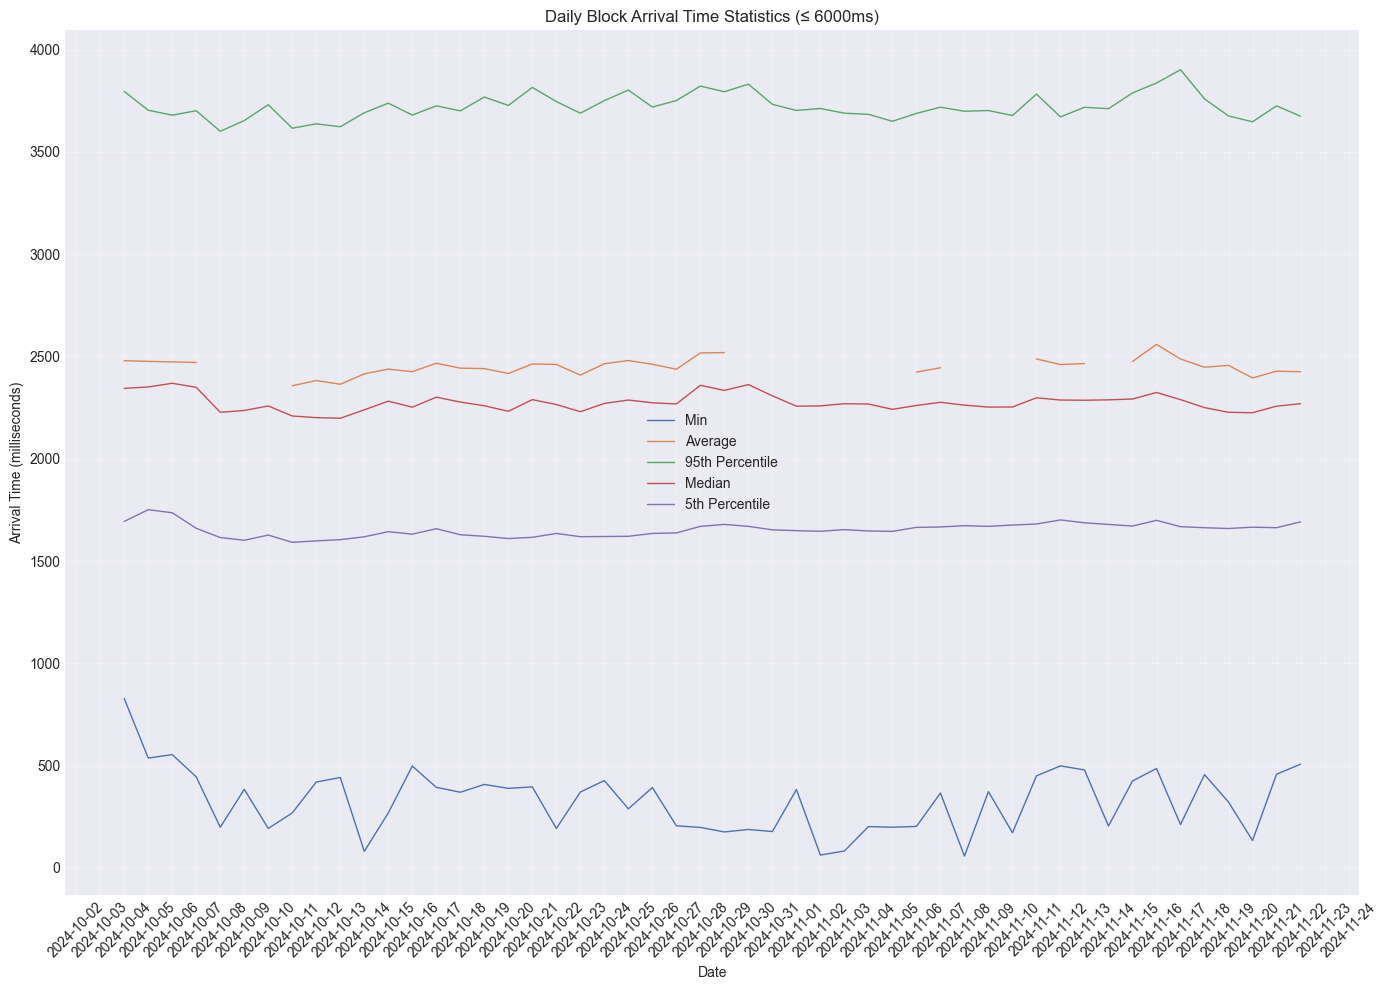

In [20]:
import matplotlib.dates as mdates

# Create figure and axis
plt.figure(figsize=(14, 10))

# Sort dataframe by time and convert to datetime
block_df = block_df.sort_values('time')
block_df['datetime'] = pd.to_datetime(block_df['time'])
block_df.set_index('datetime', inplace=True)

# Filter out values > 6000
block_df = block_df[block_df[['min', 'max', 'avg', 'p95', 'p50', 'p05']] <= 6000]

# Resample data to daily values
daily_df = block_df.resample('D').agg({
    'min': 'min',
    'max': 'max', 
    'avg': 'mean',
    'p95': 'mean',
    'p50': 'mean',
    'p05': 'mean'
})

# Plot all values
plt.plot(daily_df.index, daily_df['min'], label='Min', linewidth=1)
# plt.plot(daily_df.index, daily_df['max'], label='Max', linewidth=1)
plt.plot(daily_df.index, daily_df['avg'], label='Average', linewidth=1)
plt.plot(daily_df.index, daily_df['p95'], label='95th Percentile', linewidth=1)
plt.plot(daily_df.index, daily_df['p50'], label='Median', linewidth=1)
plt.plot(daily_df.index, daily_df['p05'], label='5th Percentile', linewidth=1)

# Customize the plot
plt.title('Daily Block Arrival Time Statistics (≤ 6000ms)')
plt.xlabel('Date')
plt.ylabel('Arrival Time (milliseconds)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [21]:
# Query for MEV relay delivered slots
block_query = text("""
    SELECT DISTINCT
        slot
    FROM mev_relay_proposer_payload_delivered FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    ORDER BY slot ASC
""")

result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
mev_slots = pd.DataFrame(result.fetchall(), columns=['slot'])

print(mev_slots)

            slot
0       10104599
1       10104600
2       10104601
3       10104602
4       10104603
...          ...
318886  10452466
318887  10452467
318888  10452468
318889  10452469
318890  10452470

[318891 rows x 1 columns]


In [22]:
# Query for all slots in time window
all_slots_query = text("""
    SELECT DISTINCT
        slot,
        slot_start_date_time as time
    FROM beacon_api_eth_v1_events_block FINAL 
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    ORDER BY slot ASC
""")

result = connection.execute(all_slots_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
all_slots = pd.DataFrame(result.fetchall(), columns=['slot', 'time'])

print(all_slots)


            slot                time
0       10104599 2024-10-04 22:00:11
1       10104600 2024-10-04 22:00:23
2       10104601 2024-10-04 22:00:35
3       10104602 2024-10-04 22:00:47
4       10104603 2024-10-04 22:00:59
...          ...                 ...
346724  10452467 2024-11-22 05:33:47
346725  10452468 2024-11-22 05:33:59
346726  10452469 2024-11-22 05:34:11
346727  10452470 2024-11-22 05:34:23
346728  10452471 2024-11-22 05:34:35

[346729 rows x 2 columns]


Total slots: 346729
Total MEV slots: 318891


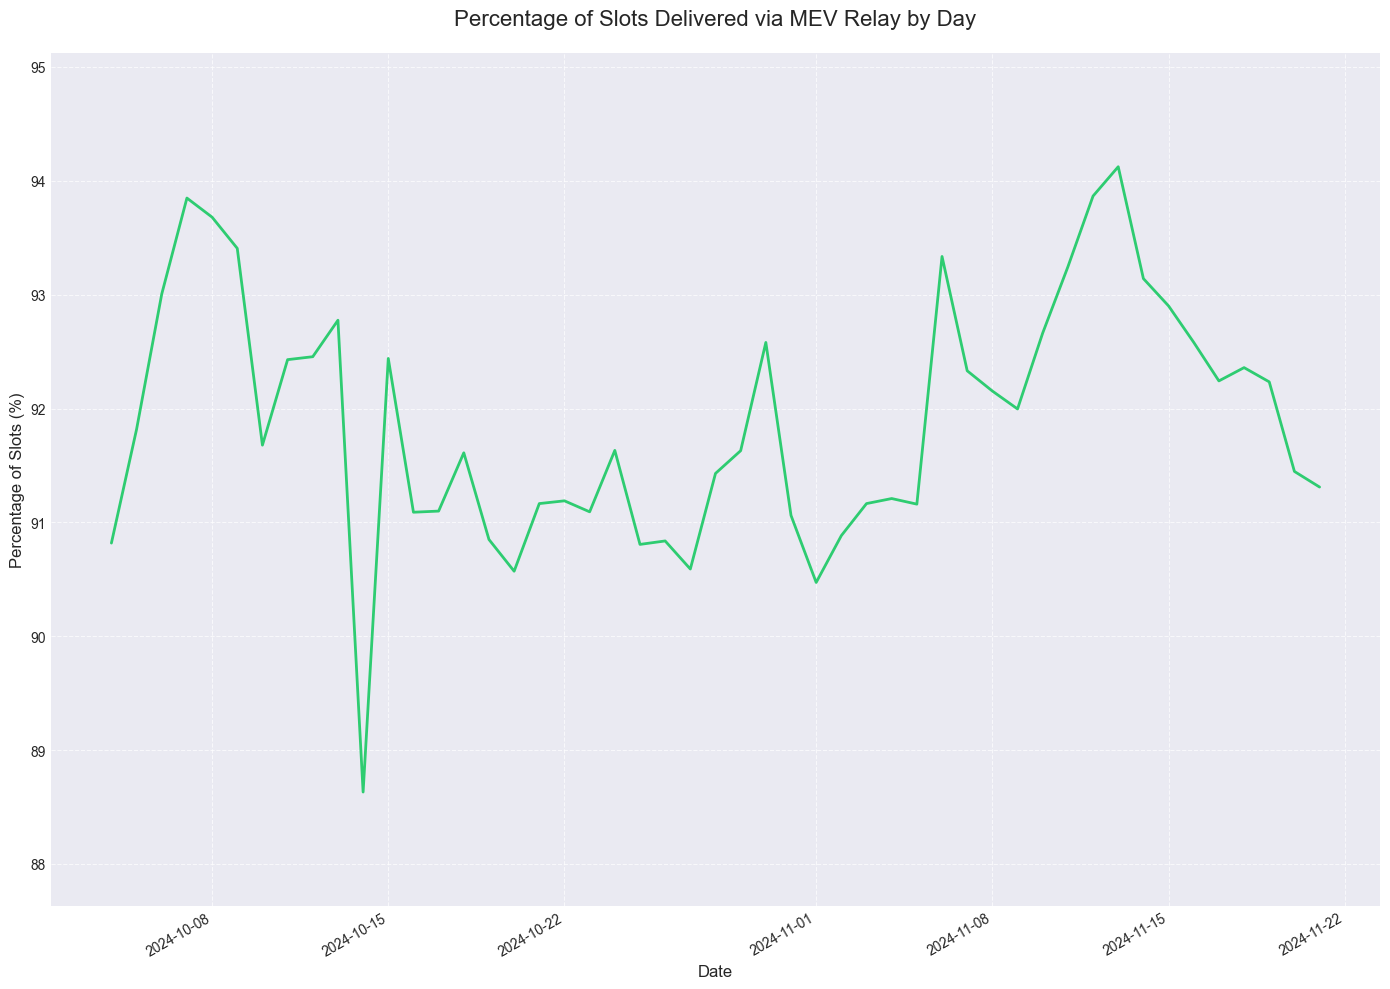

In [23]:
total_slots = len(all_slots)
total_mev_slots = len(mev_slots)

print(f"Total slots: {total_slots}")
print(f"Total MEV slots: {total_mev_slots}")

# Convert time to datetime and set as index
all_slots['time'] = pd.to_datetime(all_slots['time'])
mev_slots_with_time = pd.merge(mev_slots.copy(), all_slots[['slot', 'time']], on='slot', how='left')
mev_slots_with_time['time'] = pd.to_datetime(mev_slots_with_time['time'])

# Filter out last 5000 slots since they are probably incomplete
max_slot = all_slots['slot'].max() - 5000
mev_slots_filtered = mev_slots_with_time[mev_slots_with_time['slot'] <= max_slot]
all_slots_filtered = all_slots[all_slots['slot'] <= max_slot]

# Resample by day
mev_daily = mev_slots_filtered.resample('D', on='time').size()
all_daily = all_slots_filtered.resample('D', on='time').size()

# Calculate percentage per day
daily_percentage = (mev_daily / all_daily) * 100

# Create figure
plt.figure(figsize=(14, 10))

# Create line plot
plt.plot(daily_percentage.index, daily_percentage.values, color='#2ecc71', linewidth=2)

# Customize plot
plt.title('Percentage of Slots Delivered via MEV Relay by Day', pad=20, fontsize=16)
plt.ylabel('Percentage of Slots (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)

# Set y-axis limits with some padding
y_min = max(0, daily_percentage.min() - 1)
y_max = min(100, daily_percentage.max() + 1)
plt.ylim(y_min, y_max)

# Format dates nicely
plt.gcf().autofmt_xdate()

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [24]:
# Get non-MEV slots by filtering out MEV slots
non_mev_slots = all_slots[~all_slots['slot'].isin(mev_slots['slot'])]

print(non_mev_slots)
print(f"found {len(non_mev_slots)} non-MEV slots")


            slot                time
11      10104610 2024-10-04 22:02:23
14      10104613 2024-10-04 22:02:59
18      10104617 2024-10-04 22:03:47
22      10104621 2024-10-04 22:04:35
29      10104628 2024-10-04 22:05:59
...          ...                 ...
346699  10452442 2024-11-22 05:28:47
346703  10452446 2024-11-22 05:29:35
346710  10452453 2024-11-22 05:30:59
346716  10452459 2024-11-22 05:32:11
346728  10452471 2024-11-22 05:34:35

[28008 rows x 2 columns]
found 28008 non-MEV slots


In [108]:
# Query to get block sizes for all slots
block_sizes_query = text("""
    SELECT 
        slot,
        block_total_bytes_compressed,
        slot_start_date_time as time,
        proposer_index
    FROM canonical_beacon_block
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
""")
block_sizes = pd.DataFrame(
    connection.execute(block_sizes_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'block_total_bytes_compressed', 'time', 'proposer_index']
)

# Get proposer entities
proposer_query = text("""
    SELECT 
        `index` as proposer_index,
        entity
    FROM ethseer_validator_entity
    WHERE 
        meta_network_name = 'mainnet'
""")
proposer_entities = pd.DataFrame(
    connection.execute(proposer_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['proposer_index', 'entity']
)

# Get blob sidecar data for our slots
blob_sidecars_query = text("""
    SELECT 
        slot,
        COUNT(*) as num_blobs,
        SUM(blob_size) as total_blob_size
    FROM canonical_beacon_blob_sidecar FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, toDate(slot_start_date_time)
""")
blob_sidecars = pd.DataFrame(
    connection.execute(blob_sidecars_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'num_blobs', 'total_blob_size']
)

# Convert blob_sidecars to a dictionary
blob_sidecars_map = blob_sidecars.set_index('slot').to_dict(orient='index')

# Build combined data using block_sizes as the canonical list of slots
combined_data = block_sizes.copy()
combined_data = combined_data.merge(proposer_entities, on='proposer_index', how='left')
combined_data['num_blobs'] = combined_data['slot'].map(lambda slot: blob_sidecars_map.get(slot, {'num_blobs': 0})['num_blobs'])
combined_data['total_blob_size'] = combined_data['slot'].map(lambda slot: blob_sidecars_map.get(slot, {'total_blob_size': 0})['total_blob_size'])

# Calculate total data per slot
combined_data['total_data_per_slot'] = combined_data['block_total_bytes_compressed'] + combined_data['total_blob_size']

# Add 'via_mev' column to combined_data
combined_data['via_mev'] = combined_data['slot'].isin(mev_slots['slot'])
combined_data['date'] = pd.to_datetime(combined_data['time']).dt.date

print(combined_data)


            slot  block_total_bytes_compressed                time  \
0       10452786                         39896 2024-11-22 06:37:35   
1       10452795                         84229 2024-11-22 06:39:23   
2       10450690                         52590 2024-11-21 23:38:23   
3       10450692                         84364 2024-11-21 23:38:47   
4       10450696                         46680 2024-11-21 23:39:35   
...          ...                           ...                 ...   
346527  10299473                         40729 2024-10-31 23:34:59   
346528  10299474                         49473 2024-10-31 23:35:11   
346529  10299477                         34657 2024-10-31 23:35:47   
346530  10299478                         43777 2024-10-31 23:35:59   
346531  10299480                         43876 2024-10-31 23:36:23   

        proposer_index                entity  num_blobs  total_blob_size  \
0               531186  consensyscodefi_lido          6           786432   
1      

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/1438580768.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mev_slots_with_sizes['date'] = pd.to_datetime(mev_slots_with_sizes['time']).dt.date
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/1438580768.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mev_slots_with_sizes['date'] = pd.to_datetime(non_mev_slots_with_sizes['time']).dt.date


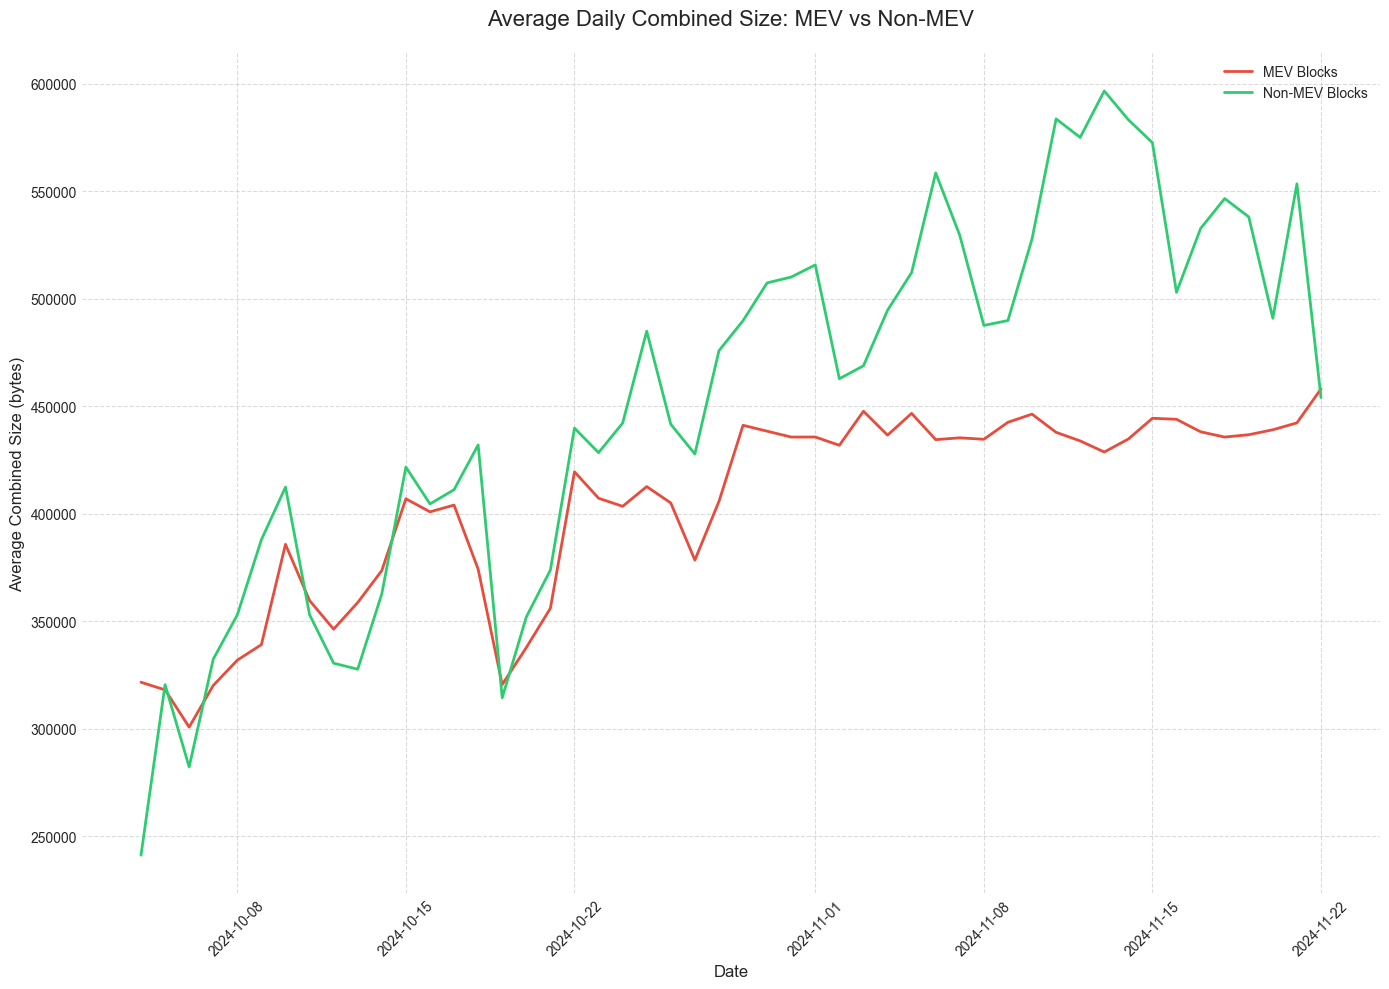

In [109]:
# Split combined_data into MEV and non-MEV dataframes
mev_slots_with_sizes = combined_data[combined_data['via_mev']]
non_mev_slots_with_sizes = combined_data[~combined_data['via_mev']]

# Convert time to date
mev_slots_with_sizes['date'] = pd.to_datetime(mev_slots_with_sizes['time']).dt.date
non_mev_slots_with_sizes['date'] = pd.to_datetime(non_mev_slots_with_sizes['time']).dt.date

# Calculate daily averages using combined size
mev_daily_avg = mev_slots_with_sizes.groupby('date')['total_data_per_slot'].mean()
non_mev_daily_avg = non_mev_slots_with_sizes.groupby('date')['total_data_per_slot'].mean()

# Create figure
plt.figure(figsize=(14, 10))

# Plot daily averages
plt.plot(mev_daily_avg.index, mev_daily_avg.values, color='#e74c3c', label='MEV Blocks', linewidth=2)
plt.plot(non_mev_daily_avg.index, non_mev_daily_avg.values, color='#2ecc71', label='Non-MEV Blocks', linewidth=2)

plt.title('Average Daily Combined Size: MEV vs Non-MEV', pad=20, fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Combined Size (bytes)', fontsize=12)
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/986758385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mev_data['block_pct'] = non_mev_data['block_total_bytes_compressed'] / non_mev_data['total_data_per_slot'] * 100
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/986758385.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mev_data['blob_pct'] = non_mev_data['total_blob_size'] / non_mev_data['total_data_per_slot'] * 100
/var/folders/fq/bp58gxy12nd2b32pw1y8wy

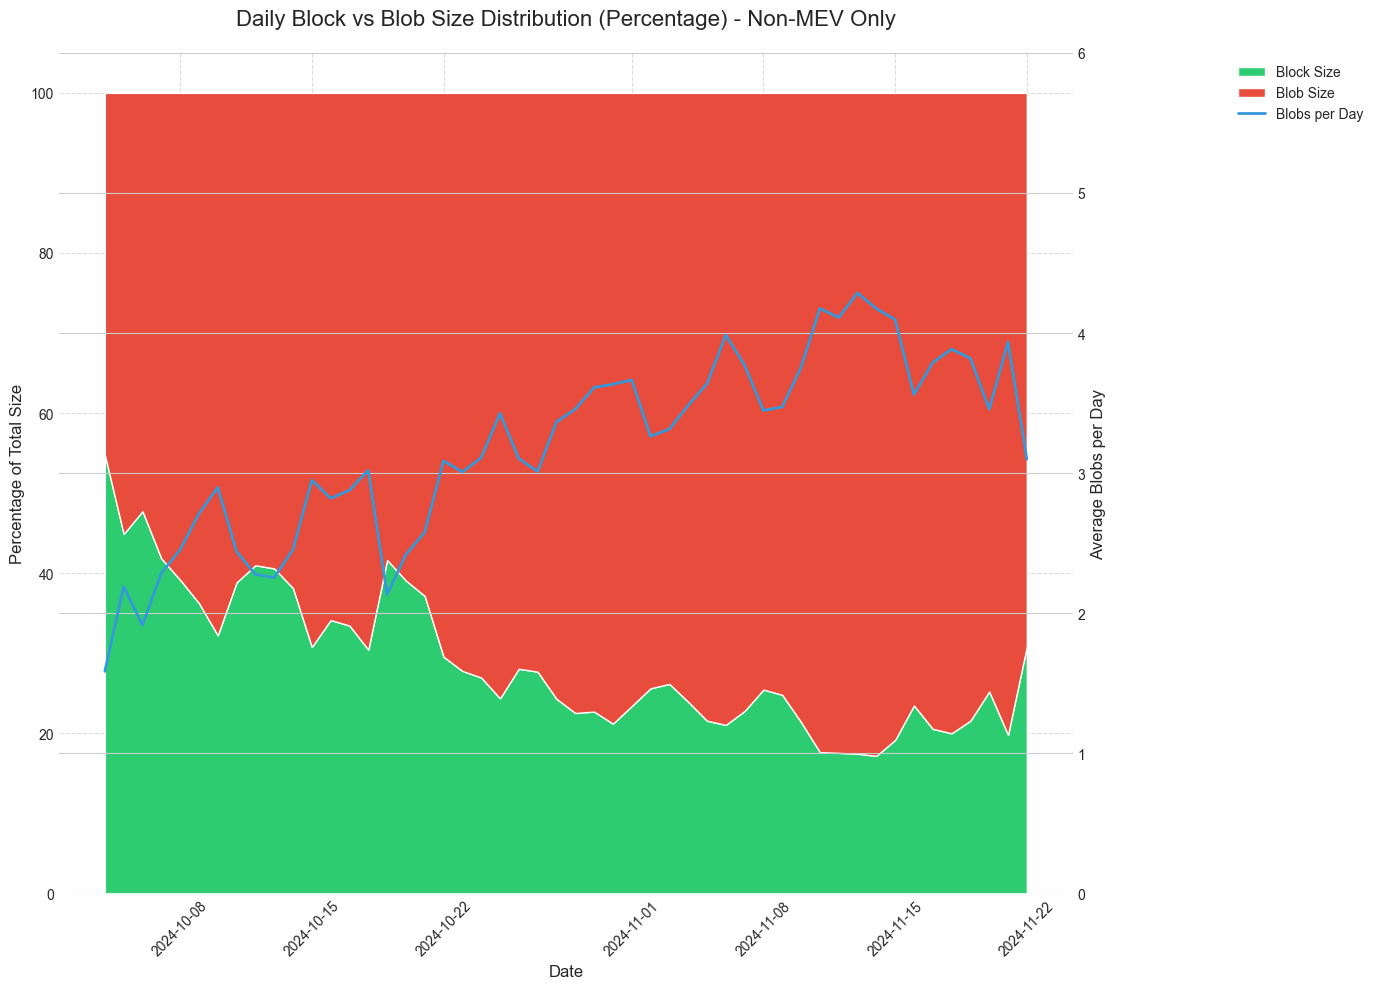

In [110]:
# Filter for non-MEV slots
non_mev_data = combined_data[~combined_data['via_mev']]

# Calculate percentages
non_mev_data['block_pct'] = non_mev_data['block_total_bytes_compressed'] / non_mev_data['total_data_per_slot'] * 100
non_mev_data['blob_pct'] = non_mev_data['total_blob_size'] / non_mev_data['total_data_per_slot'] * 100

# Convert time to date
non_mev_data['date'] = pd.to_datetime(non_mev_data['time']).dt.date

# Calculate daily averages
daily_block_pct = non_mev_data.groupby('date')['block_pct'].mean()
daily_blob_pct = non_mev_data.groupby('date')['blob_pct'].mean()
daily_blobs = non_mev_data.groupby('date')['num_blobs'].mean()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 10))
ax2 = ax1.twinx()

# Plot stacked area on left axis
ax1.stackplot(daily_block_pct.index, 
              [daily_block_pct.values, daily_blob_pct.values],
              labels=['Block Size', 'Blob Size'],
              colors=['#2ecc71', '#e74c3c'])

# Plot blobs per day on right axis
ax2.plot(daily_blobs.index, daily_blobs.values, color='#3498db', label='Blobs per Day', linewidth=2)

ax1.set_title('Daily Block vs Blob Size Distribution (Percentage) - Non-MEV Only', pad=20, fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Percentage of Total Size', fontsize=12)
ax2.set_ylabel('Average Blobs per Day', fontsize=12)
ax2.set_ylim(0, 6)  # Set y-axis limits for blobs per day

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.15, 1), loc='upper left')

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/1452959493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mev_slots_with_sizes['date'] = pd.to_datetime(mev_slots_with_sizes['time']).dt.date
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/1452959493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mev_slots_with_sizes['date'] = pd.to_datetime(non_mev_slots_with_sizes['time']).dt.date


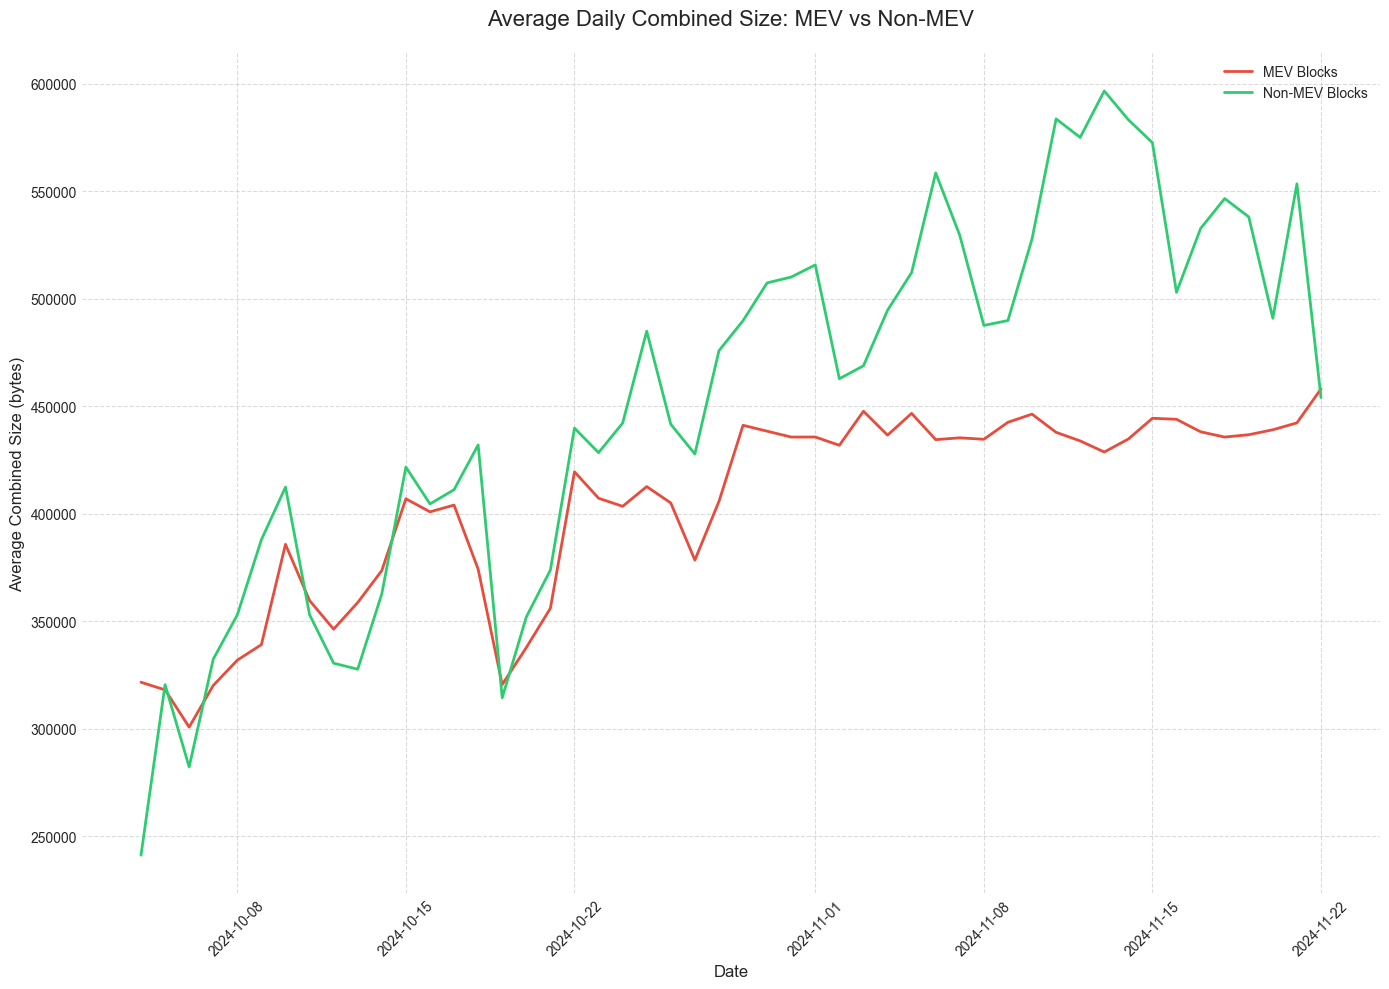

In [111]:
# Convert slot to datetime and extract date
mev_slots_with_sizes['date'] = pd.to_datetime(mev_slots_with_sizes['time']).dt.date
non_mev_slots_with_sizes['date'] = pd.to_datetime(non_mev_slots_with_sizes['time']).dt.date

# Calculate daily averages using combined size
mev_daily_avg = mev_slots_with_sizes.groupby('date')['total_data_per_slot'].mean()
non_mev_daily_avg = non_mev_slots_with_sizes.groupby('date')['total_data_per_slot'].mean()

# Create figure
plt.figure(figsize=(14, 10))

# Plot daily averages
plt.plot(mev_daily_avg.index, mev_daily_avg.values, color='#e74c3c', label='MEV Blocks', linewidth=2)
plt.plot(non_mev_daily_avg.index, non_mev_daily_avg.values, color='#2ecc71', label='Non-MEV Blocks', linewidth=2)

plt.title('Average Daily Combined Size: MEV vs Non-MEV', pad=20, fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Combined Size (bytes)', fontsize=12)
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [112]:

query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as arrival_time,
        meta_client_geo_country as country,
        slot
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
        AND propagation_slot_start_diff < 6000
    GROUP BY time, country, slot
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
country_slot_arrival_times = pd.DataFrame(result.fetchall(), columns=['time', 'arrival_time', 'country', 'slot'])

if len(country_slot_arrival_times) == 0:
    raise ValueError("No country arrival times found for the given time range")

print(f"Found {len(country_slot_arrival_times)} country arrival times for the given time range")


Found 2220328 country arrival times for the given time range


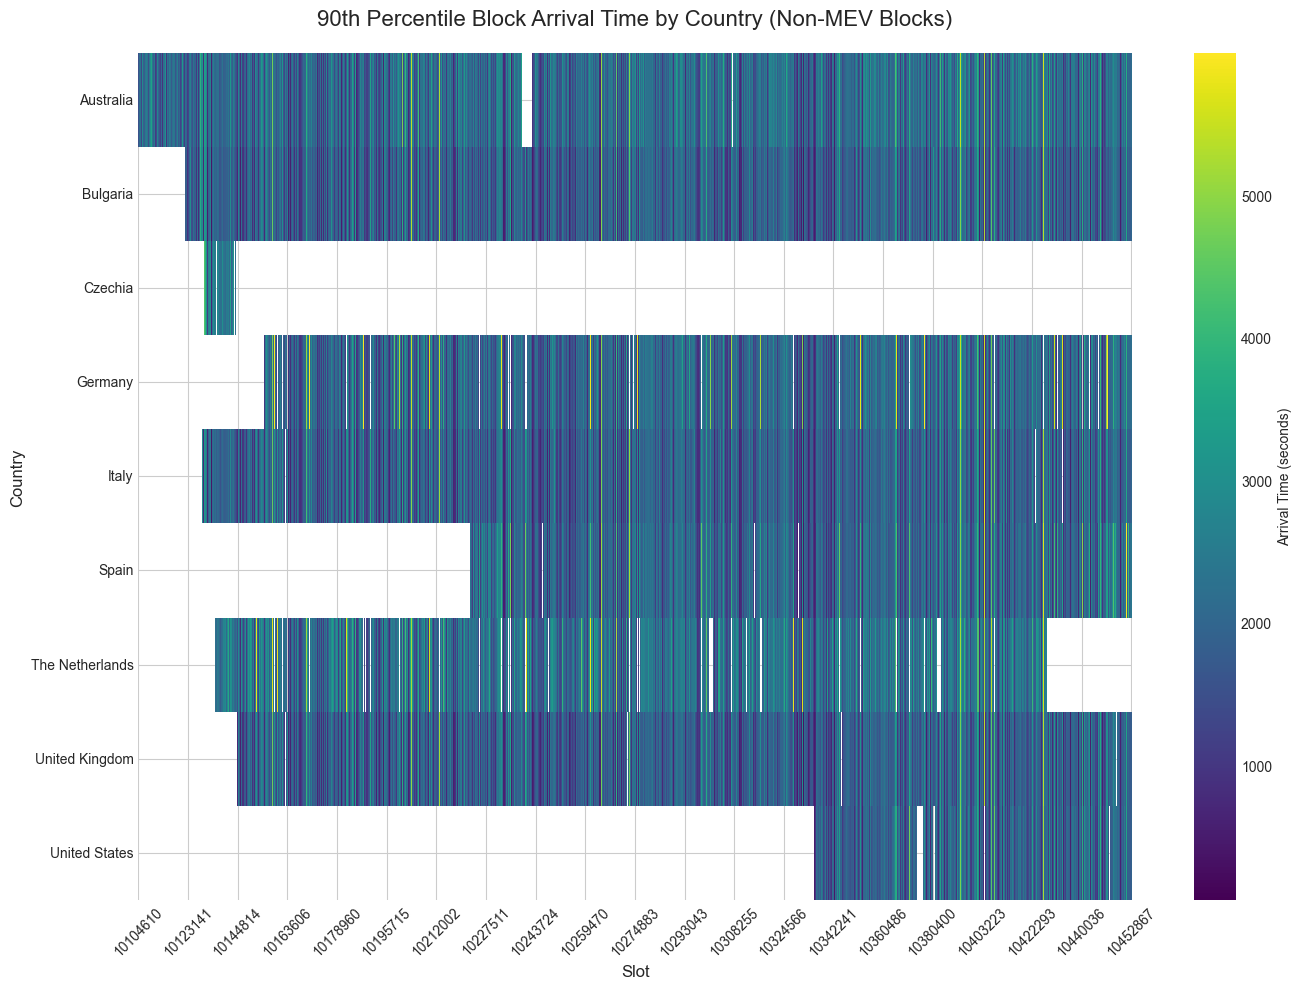

In [113]:
# Create figure
plt.figure(figsize=(14, 10))

# Prepare data for heatmap
pivot_data = country_slot_arrival_times[~country_slot_arrival_times['slot'].isin(mev_slots['slot'])].pivot_table(
    values='arrival_time',
    index='country', 
    columns='slot',
    aggfunc=lambda x: np.percentile(x, 90)
)

# Calculate number of slots to skip for ~20 buckets
num_slots = len(pivot_data.columns)
skip_slots = max(1, num_slots // 20)

# Create heatmap
sns.heatmap(
    pivot_data,
    cmap='viridis',
    cbar_kws={'label': 'Arrival Time (seconds)'},
    xticklabels=skip_slots,  # Show labels based on calculated skip value
    yticklabels=True
)

plt.title('90th Percentile Block Arrival Time by Country (Non-MEV Blocks)', pad=20, fontsize=16)
plt.ylabel('Country', fontsize=12)
plt.xlabel('Slot', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


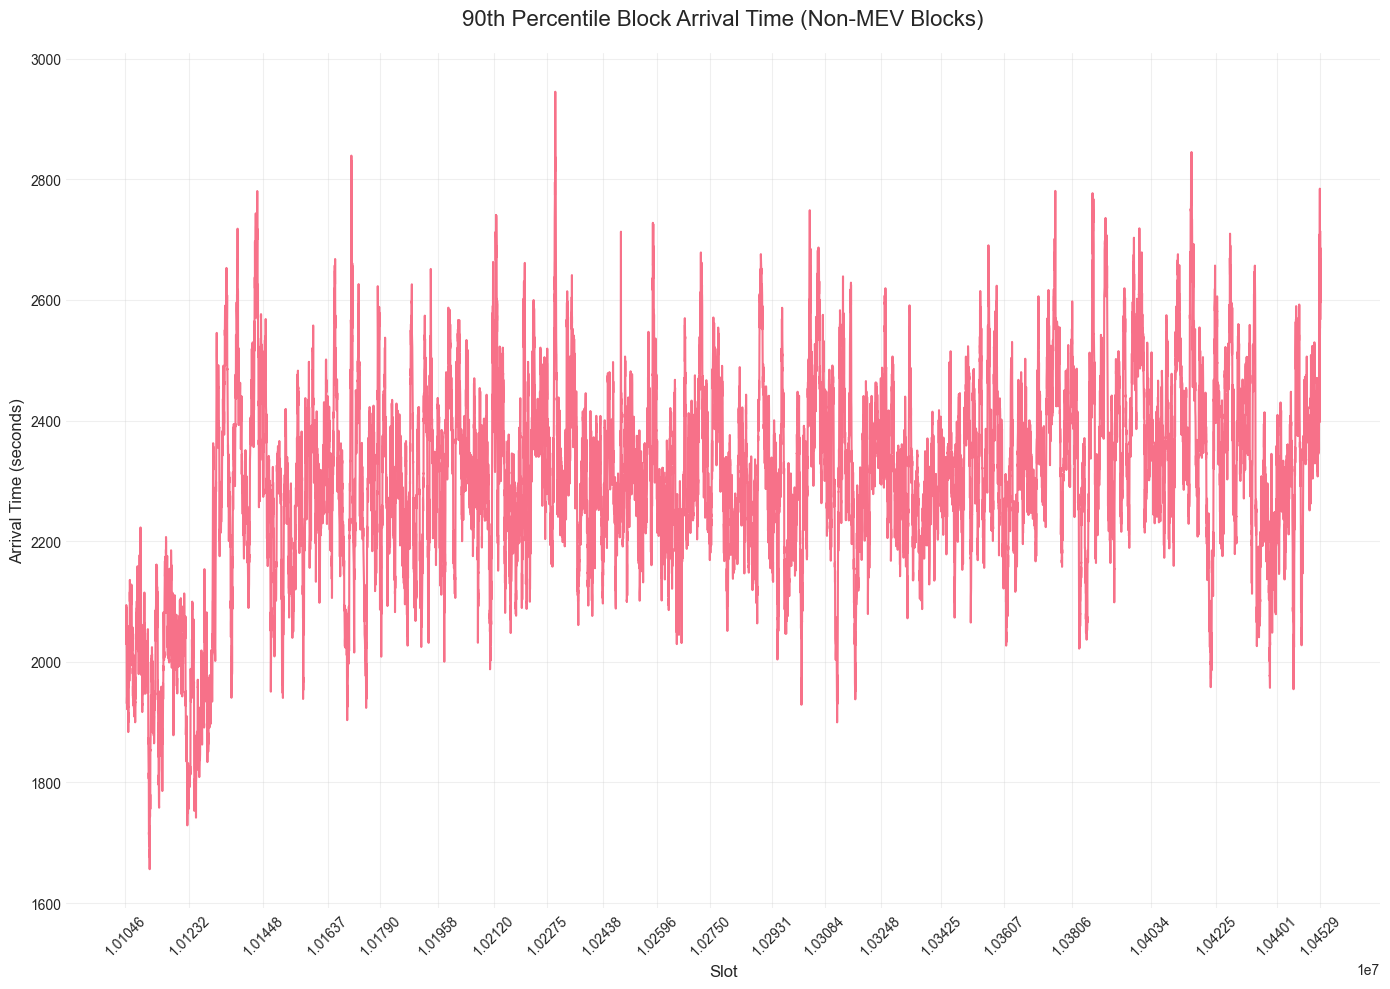

In [114]:
# Create figure
plt.figure(figsize=(14, 10))

# Get p90 arrival time across all countries and smooth with rolling average
pivot_data = country_slot_arrival_times[~country_slot_arrival_times['slot'].isin(mev_slots_with_sizes['slot'])].groupby('slot')['arrival_time'].quantile(0.9).reset_index()
pivot_data['arrival_time'] = pivot_data['arrival_time'].rolling(window=50, center=True).mean()

# Create line plot
plt.plot(pivot_data['slot'], pivot_data['arrival_time'])

# Set x-axis ticks
num_slots = len(pivot_data)
skip_slots = max(1, num_slots // 20)
plt.xticks(pivot_data['slot'][::skip_slots], rotation=45)

plt.title('90th Percentile Block Arrival Time (Non-MEV Blocks)', pad=20, fontsize=16)
plt.xlabel('Slot', fontsize=12)
plt.ylabel('Arrival Time (seconds)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [115]:

query = text("""
    SELECT
        slot_start_date_time as time,
        max(propagation_slot_start_diff) as max_arrival_time,
        quantile(0.95)(propagation_slot_start_diff) as p95_arrival_time,
        avg(propagation_slot_start_diff) as avg_arrival_time,
        quantile(0.50)(propagation_slot_start_diff) as p50_arrival_time,
        quantile(0.05)(propagation_slot_start_diff) as p05_arrival_time,
        quantile(0.01)(propagation_slot_start_diff) as p01_arrival_time,
        quantile(0.99)(propagation_slot_start_diff) as p99_arrival_time,
        min(propagation_slot_start_diff) as min_arrival_time,
        slot
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
        AND propagation_slot_start_diff < 6000
    GROUP BY time, slot
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
aggregated_arrival_times = pd.DataFrame(result.fetchall(), columns=[
    'time', 'max_arrival_time', 'p95_arrival_time', 'avg_arrival_time', 'p50_arrival_time', 'p05_arrival_time', 'p01_arrival_time', 'p99_arrival_time', 'min_arrival_time', 'slot'
])

if len(aggregated_arrival_times) == 0:
    raise ValueError("No aggregated arrival times found for the given time range")

print(f"Found {len(aggregated_arrival_times)} aggregated arrival times for the given time range")
print(aggregated_arrival_times)


Found 346642 aggregated arrival times for the given time range
                      time  max_arrival_time  p95_arrival_time  \
0      2024-10-05 01:37:47              3315           3299.40   
1      2024-10-12 15:23:23              2409           2361.00   
2      2024-11-17 18:08:47              2769           2662.35   
3      2024-10-30 08:54:35              2906           2834.00   
4      2024-10-19 07:21:11              1820           1786.40   
...                    ...               ...               ...   
346637 2024-10-27 04:05:23              2664           2539.80   
346638 2024-11-21 23:25:23              3082           2992.40   
346639 2024-10-13 09:24:47              2238           2216.00   
346640 2024-10-30 21:36:59              4580           4514.75   
346641 2024-11-18 00:22:35              3764           3676.25   

        avg_arrival_time  p50_arrival_time  p05_arrival_time  \
0            3159.000000            3159.0           3018.60   
1            200

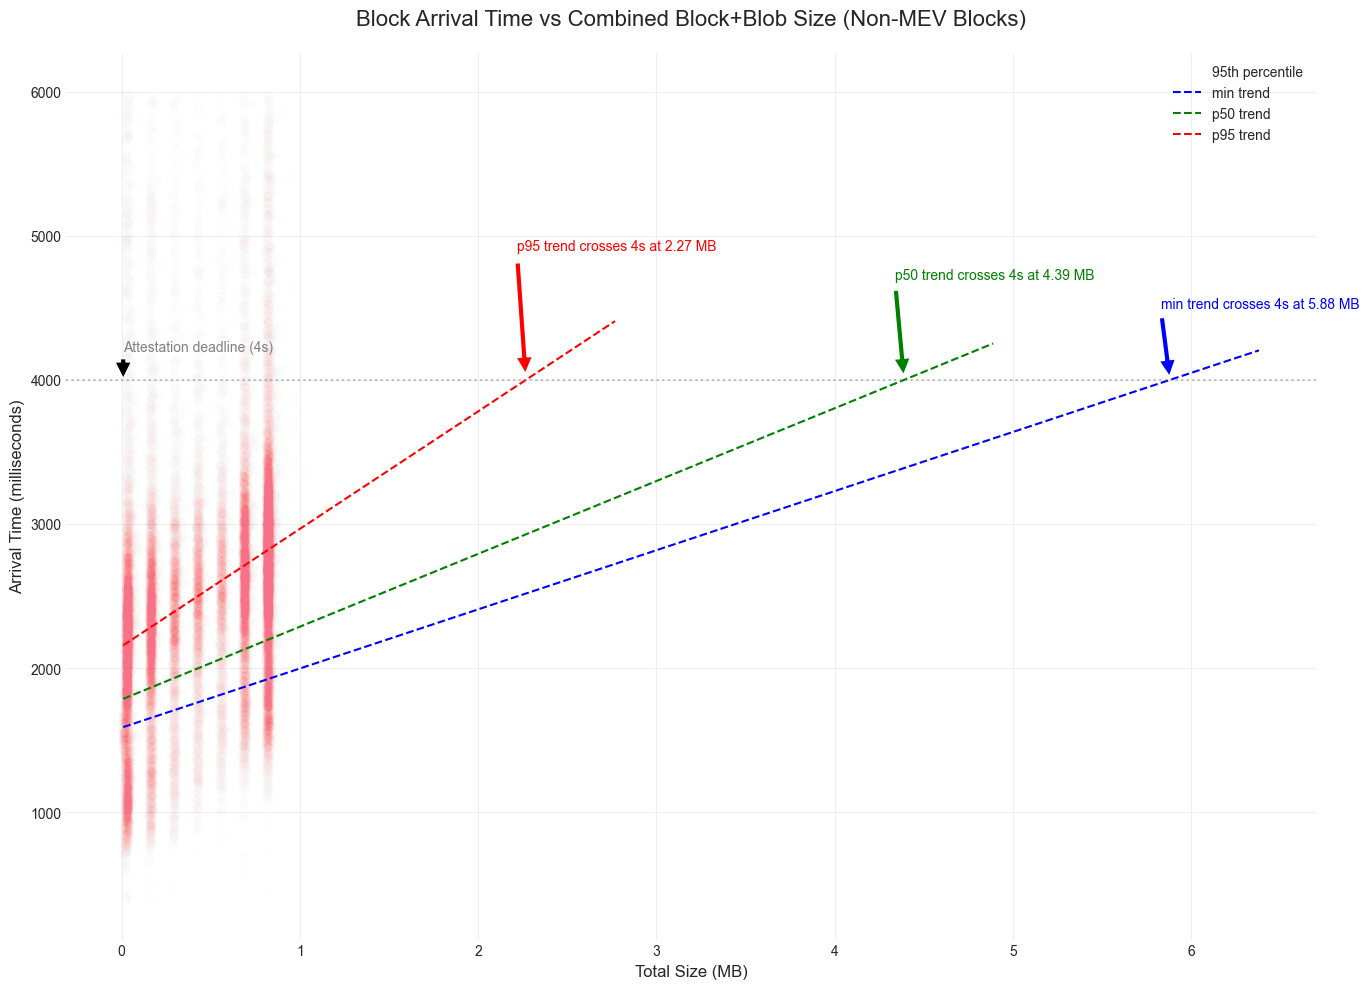

In [116]:
# Create figure
plt.figure(figsize=(14, 10))

# Merge with size data
plot_data = aggregated_arrival_times.merge(non_mev_slots_with_sizes[['slot', 'block_total_bytes_compressed', 'total_blob_size']], on='slot')
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Sort by size for trend lines
plot_data = plot_data.sort_values('total_size_mb')

# Create scatter plot for p95
plt.scatter(plot_data['total_size_mb'], plot_data['p95_arrival_time'], alpha=0.005, label='95th percentile')

# Create trend lines for min, p50, p95
for metric, color, label in [
    ('min_arrival_time', 'blue', 'min'),
    ('p50_arrival_time', 'green', 'p50'), 
    ('p95_arrival_time', 'red', 'p95')
]:
    # Trend line
    z = np.polyfit(plot_data['total_size_mb'], plot_data[metric], 1)
    p_fit = np.poly1d(z)
    
    # Calculate intersection with 4000ms line
    max_size = (4000 - z[1]) / z[0]
    x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)
    plt.plot(x_range, p_fit(x_range), f"--", color=color, alpha=1, label=f'{label} trend')
    
    # Add annotation
    plt.annotate(f'{label} trend crosses 4s at {max_size:.2f} MB',
                xy=(max_size, 4000),
                xytext=(max_size-0.05, 4500 + 200*(['min', 'p50', 'p95'].index(label))),
                arrowprops=dict(facecolor=color, shrink=0.05),
                color=color)

plt.axhline(y=4000, color='gray', linestyle=':', alpha=0.5)
plt.annotate('Attestation deadline (4s)', xy=(plot_data['total_size_mb'].min(), 4000), 
            xytext=(plot_data['total_size_mb'].min(), 4200),
            arrowprops=dict(facecolor='black', shrink=0.05),
            color='gray')
plt.legend()

plt.title('Block Arrival Time vs Combined Block+Blob Size (Non-MEV Blocks)', pad=20, fontsize=16)
plt.xlabel('Total Size (MB)', fontsize=12)
plt.ylabel('Arrival Time (milliseconds)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


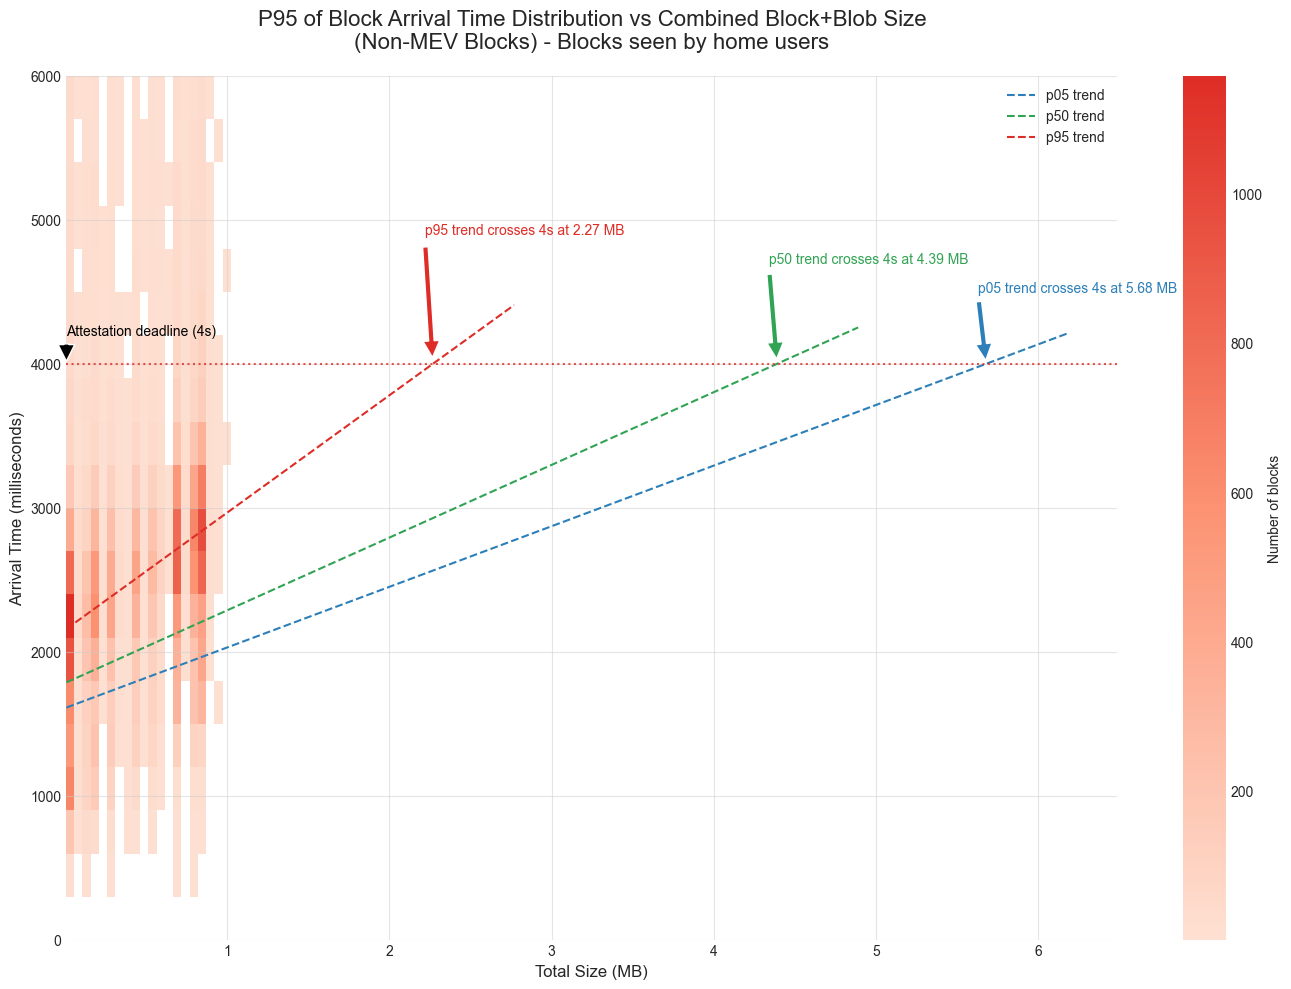

In [155]:
# Create figure
plt.figure(figsize=(14, 10))

# Merge with size data
plot_data = aggregated_arrival_times.merge(non_mev_slots_with_sizes[['slot', 'block_total_bytes_compressed', 'total_blob_size']], on='slot')
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Create 2D histogram
h, xedges, yedges = np.histogram2d(
    plot_data['total_size_mb'],
    plot_data['p95_arrival_time'],
    bins=20,
    range=[[plot_data['total_size_mb'].min(), plot_data['total_size_mb'].max()],
           [0, 6000]]  # Limit y-axis to 6s for better visibility
)

# Create custom colormap with transparency for zero values
colors = ['#fee0d2', '#fc9272', '#de2d26']  # Light pink to dark red
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('custom_reds', colors)
cmap.set_under('none')  # Set values below vmin to transparent

# Create heatmap
plt.imshow(h.T, origin='lower', aspect='auto', 
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=cmap,
           vmin=0.1)  # Set minimum value slightly above 0

# Add colorbar
plt.colorbar(label='Number of blocks')

# Create trend lines for min, p50, p95
for metric, color, label in [
    ('p05_arrival_time', '#2c7fb8', 'p05'),  # Blue
    ('p50_arrival_time', '#31a354', 'p50'),   # Green
    ('p95_arrival_time', '#de2d26', 'p95')    # Red
]:
    # Trend line
    z = np.polyfit(plot_data['total_size_mb'], plot_data[metric], 1)
    p_fit = np.poly1d(z)
    
    # Calculate intersection with 4000ms line
    max_size = (4000 - z[1]) / z[0]
    x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)
    plt.plot(x_range, p_fit(x_range), f"--", color=color, alpha=1, label=f'{label} trend')
    
    # Add annotation
    plt.annotate(f'{label} trend crosses 4s at {max_size:.2f} MB',
                xy=(max_size, 4000),
                xytext=(max_size-0.05, 4500 + 200*(['p05', 'p50', 'p95'].index(label))),
                arrowprops=dict(facecolor=color, shrink=0.05),
                color=color)

# Add 4s deadline line
plt.axhline(y=4000, color='#de2d26', linestyle=':', alpha=0.8)
plt.annotate('Attestation deadline (4s)', xy=(plot_data['total_size_mb'].min(), 4000), 
            xytext=(plot_data['total_size_mb'].min(), 4200),
            arrowprops=dict(facecolor='black', shrink=0.1),
            color='black')

plt.legend()
plt.title('P95 of Block Arrival Time Distribution vs Combined Block+Blob Size\n(Non-MEV Blocks) - Blocks seen by home users', pad=20, fontsize=16)
plt.xlabel('Total Size (MB)', fontsize=12)
plt.ylabel('Arrival Time (milliseconds)', fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


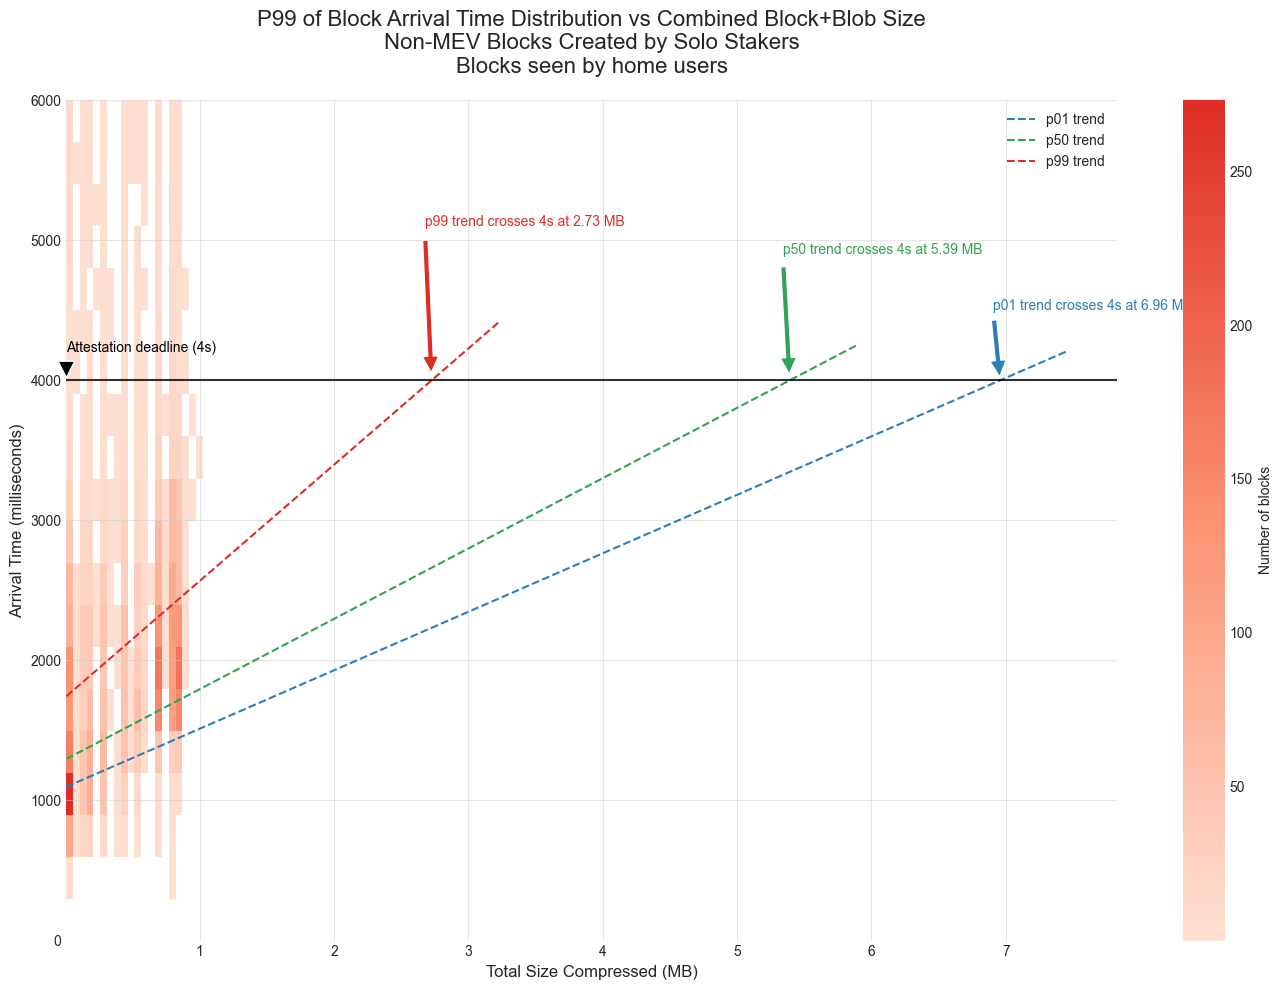

In [154]:
# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(non_mev_slots_with_sizes[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'solo_stakers'"))
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Create 2D histogram
h, xedges, yedges = np.histogram2d(
    plot_data['total_size_mb'],
    plot_data['p99_arrival_time'],
    bins=20,
    range=[
        [plot_data['total_size_mb'].min(), plot_data['total_size_mb'].max()],
        [0, 6000]  # Limit y-axis to 6s for better visibility
    ]
)

# Create custom colormap with transparency for zero values
colors = ['#fee0d2', '#fc9272', '#de2d26']  # Light pink to dark red
cmap = LinearSegmentedColormap.from_list('custom_reds', colors)
cmap.set_under('none')  # Set values below vmin to transparent

# Create heatmap
plt.imshow(h.T, 
    origin='lower',
    aspect='auto',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap=cmap,
    vmin=0.1  # Set minimum value slightly above 0
)

plt.colorbar(label='Number of blocks')

# Add trend lines and annotations
metrics = [
    ('p01_arrival_time', '#2c7fb8', 'p01'),  # Blue  
    ('p50_arrival_time', '#31a354', 'p50'),  # Green
    ('p99_arrival_time', '#de2d26', 'p99')   # Red
]

for metric, color, label in metrics:
    # Calculate trend line
    z = np.polyfit(plot_data['total_size_mb'], plot_data[metric], 1)
    p_fit = np.poly1d(z)
    
    # Find intersection with 4s deadline
    max_size = (4000 - z[1]) / z[0]
    x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)
    
    # Plot trend line
    plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=1, label=f'{label} trend')
    
    # Add annotation
    label_idx = ['p01', 'p05', 'p50', 'p99'].index(label)
    plt.annotate(
        f'{label} trend crosses 4s at {max_size:.2f} MB',
        xy=(max_size, 4000),
        xytext=(max_size-0.05, 4500 + 200*label_idx),
        arrowprops=dict(facecolor=color, shrink=0.05),
        color=color
    )

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(plot_data['total_size_mb'].min(), 4000),
    xytext=(plot_data['total_size_mb'].min(), 4200),
    arrowprops=dict(facecolor='black', shrink=0.1),
    color='black'
)

# Customize plot
plt.legend()
plt.title('P99 of Block Arrival Time Distribution vs Combined Block+Blob Size\n'
          'Non-MEV Blocks Created by Solo Stakers\n'
          'Blocks seen by home users', 
          pad=20, fontsize=16)
plt.xlabel('Total Size Compressed (MB)', fontsize=12)
plt.ylabel('Arrival Time (milliseconds)', fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


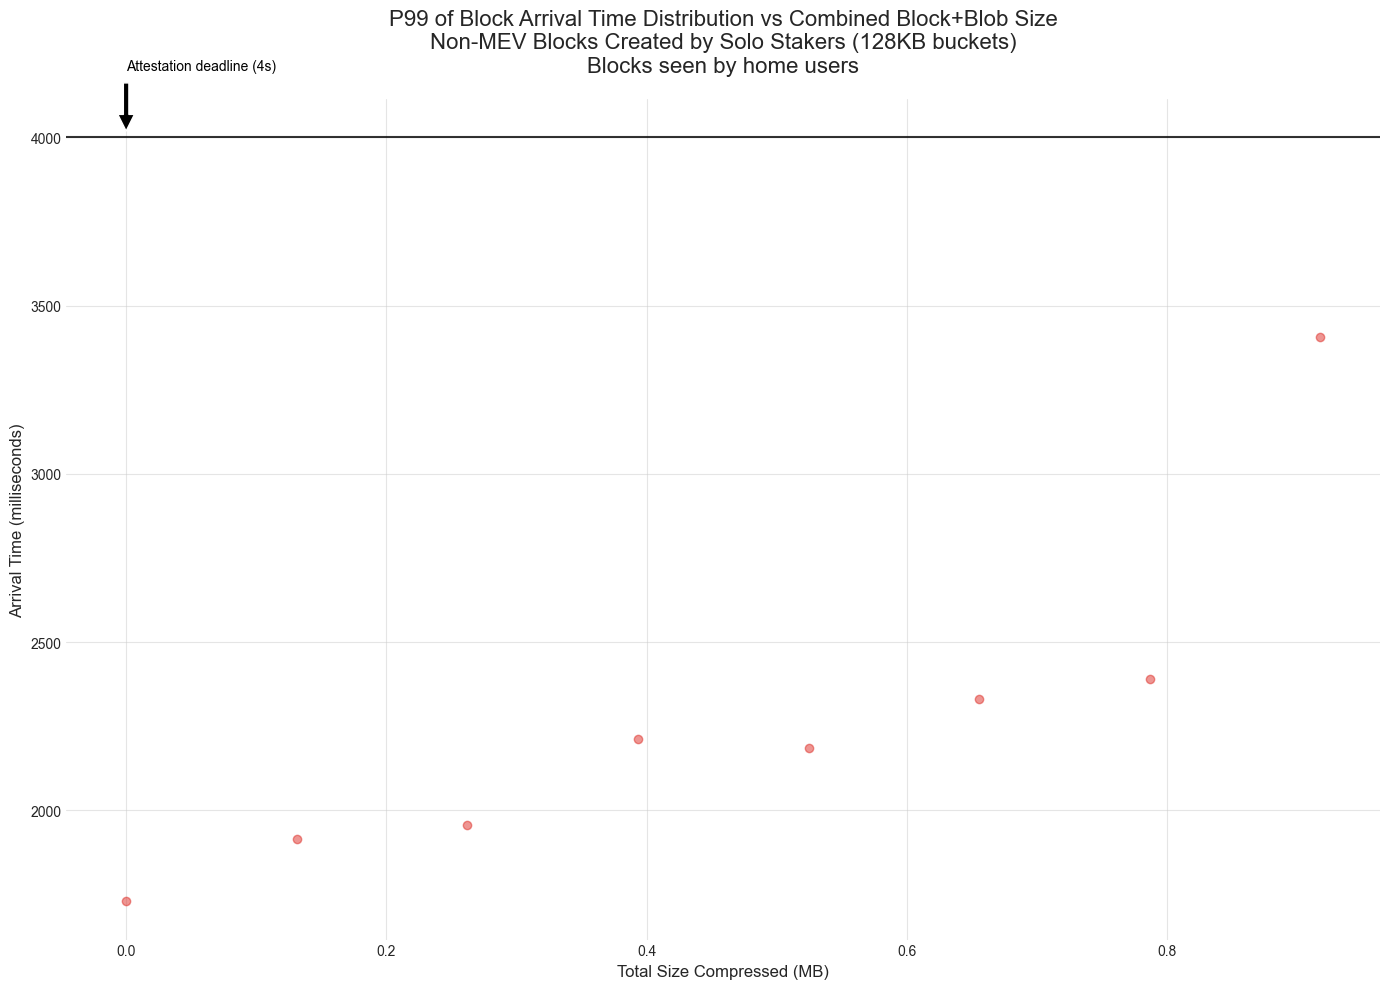

In [157]:
# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(non_mev_slots_with_sizes[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'solo_stakers'"))

# Calculate total size and bucket into 128KB intervals
plot_data['total_size'] = plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']
plot_data['size_bucket'] = (plot_data['total_size'] // (128 * 1024)) * (128 * 1024)
plot_data['size_bucket_mb'] = plot_data['size_bucket'] / 1_000_000

# Group by bucket and calculate mean p99
bucketed_data = plot_data.groupby('size_bucket_mb')['p99_arrival_time'].mean().reset_index()

# Create scatter plot
plt.scatter(bucketed_data['size_bucket_mb'], bucketed_data['p99_arrival_time'], alpha=0.5, color='#de2d26')

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(bucketed_data['size_bucket_mb'].min(), 4000),
    xytext=(bucketed_data['size_bucket_mb'].min(), 4200),
    arrowprops=dict(facecolor='black', shrink=0.1),
    color='black'
)

# Customize plot
plt.title('P99 of Block Arrival Time Distribution vs Combined Block+Blob Size\n'
          'Non-MEV Blocks Created by Solo Stakers (128KB buckets)\n'
          'Blocks seen by home users', 
          pad=20, fontsize=16)
plt.xlabel('Total Size Compressed (MB)', fontsize=12)
plt.ylabel('Arrival Time (milliseconds)', fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


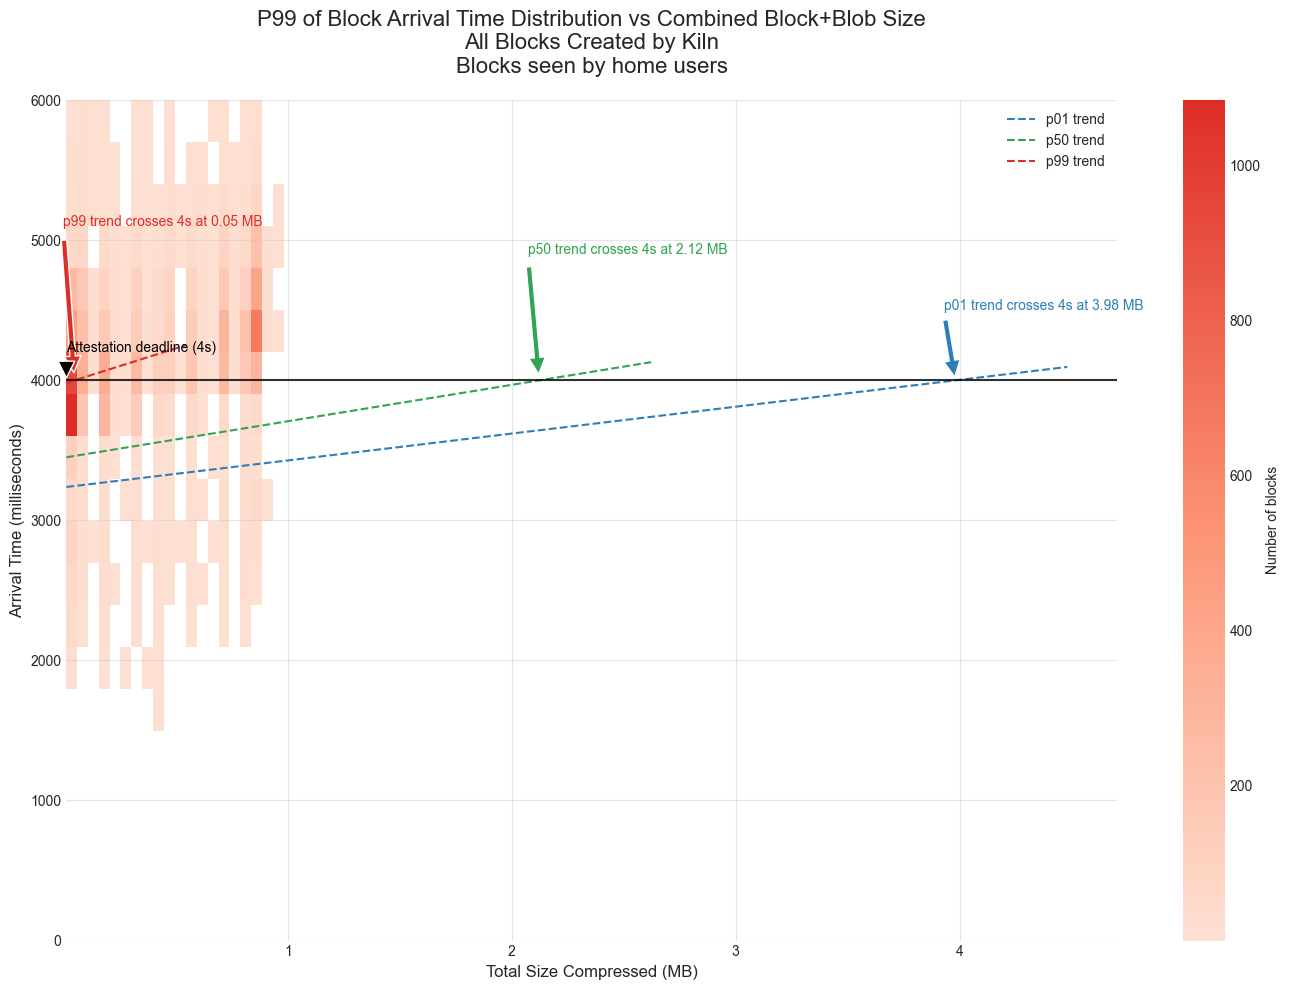

In [120]:
# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(combined_data[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'kiln'"))
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Create 2D histogram
h, xedges, yedges = np.histogram2d(
    plot_data['total_size_mb'],
    plot_data['p99_arrival_time'],
    bins=20,
    range=[
        [plot_data['total_size_mb'].min(), plot_data['total_size_mb'].max()],
        [0, 6000]  # Limit y-axis to 6s for better visibility
    ]
)

# Create custom colormap with transparency for zero values
colors = ['#fee0d2', '#fc9272', '#de2d26']  # Light pink to dark red
cmap = LinearSegmentedColormap.from_list('custom_reds', colors)
cmap.set_under('none')  # Set values below vmin to transparent

# Create heatmap
plt.imshow(h.T, 
    origin='lower',
    aspect='auto',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap=cmap,
    vmin=0.1  # Set minimum value slightly above 0
)

plt.colorbar(label='Number of blocks')

# Add trend lines and annotations
metrics = [
    ('p01_arrival_time', '#2c7fb8', 'p01'),  # Blue  
    ('p50_arrival_time', '#31a354', 'p50'),  # Green
    ('p99_arrival_time', '#de2d26', 'p99')   # Red
]

for metric, color, label in metrics:
    # Calculate trend line
    z = np.polyfit(plot_data['total_size_mb'], plot_data[metric], 1)
    p_fit = np.poly1d(z)
    
    # Find intersection with 4s deadline
    max_size = (4000 - z[1]) / z[0]
    
    # Only plot if max_size is positive
    if max_size > 0:
        x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)
        
        # Plot trend line
        plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=1, label=f'{label} trend')
        
        # Add annotation
        label_idx = ['p01', 'p05', 'p50', 'p99'].index(label)
        plt.annotate(
            f'{label} trend crosses 4s at {max_size:.2f} MB',
            xy=(max_size, 4000),
            xytext=(max_size-0.05, 4500 + 200*label_idx),
            arrowprops=dict(facecolor=color, shrink=0.05),
            color=color
        )

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(plot_data['total_size_mb'].min(), 4000),
    xytext=(plot_data['total_size_mb'].min(), 4200),
    arrowprops=dict(facecolor='black', shrink=0.1),
    color='black'
)

# Customize plot
plt.legend()
plt.title('P99 of Block Arrival Time Distribution vs Combined Block+Blob Size\n'
          'All Blocks Created by Kiln\n'
          'Blocks seen by home users', 
          pad=20, fontsize=16)
plt.xlabel('Total Size Compressed (MB)', fontsize=12)
plt.ylabel('Arrival Time (milliseconds)', fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


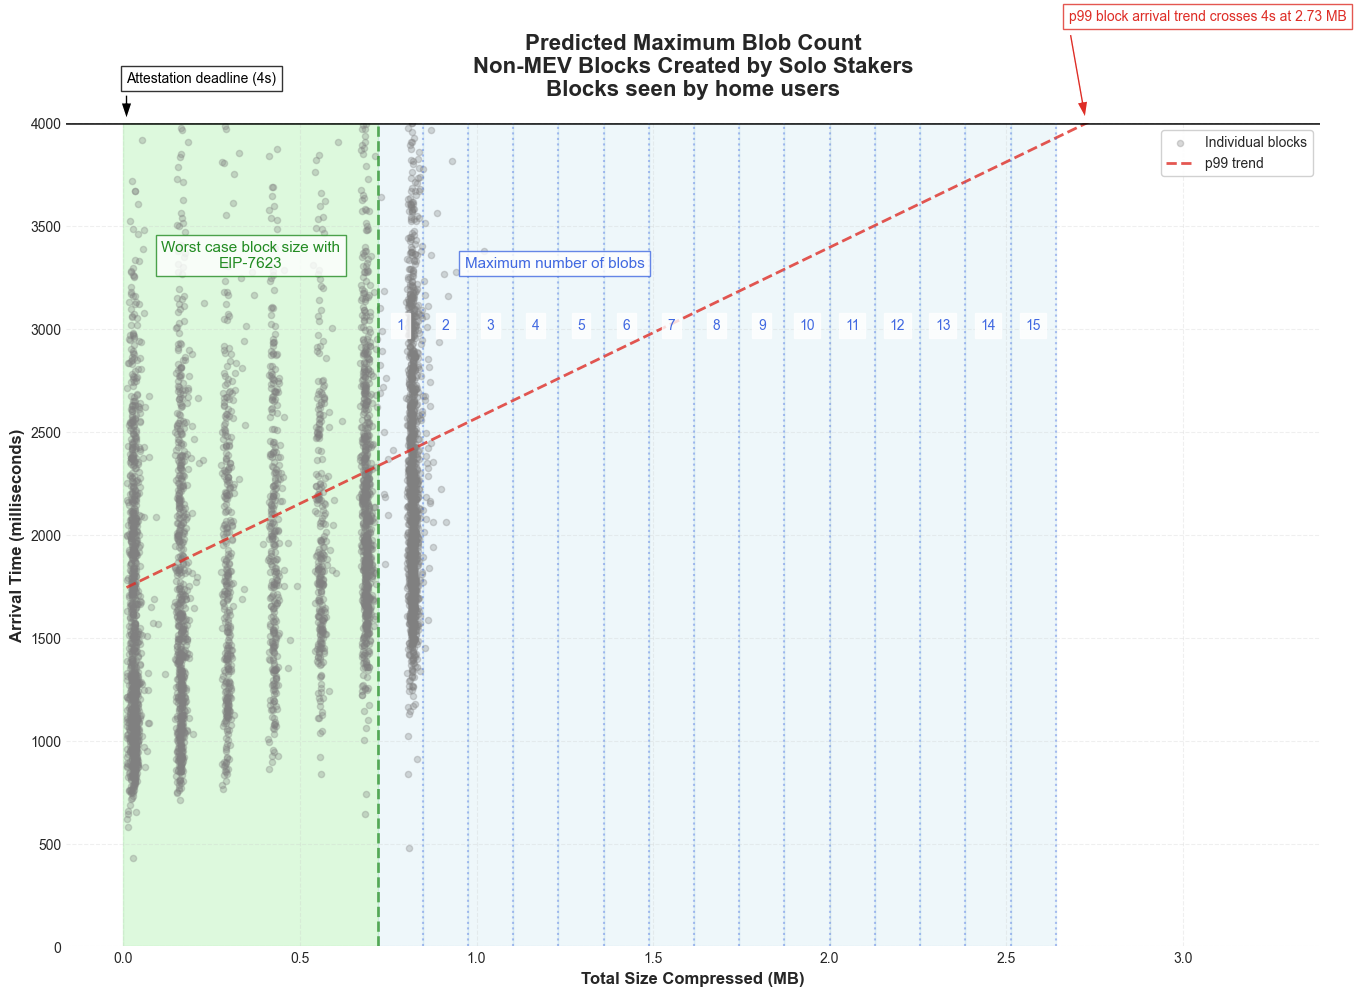

In [174]:
# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(non_mev_slots_with_sizes[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'solo_stakers'"))
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Plot scatter points
plt.scatter(plot_data['total_size_mb'], plot_data['p99_arrival_time'], 
           alpha=0.3, s=20, color='gray', label='Individual blocks')

# Add trend line and annotation
metric = 'p99_arrival_time'
color = '#de2d26'  # Red
label = 'p99'

# Calculate trend line
z = np.polyfit(plot_data['total_size_mb'], plot_data[metric], 1)
p_fit = np.poly1d(z)

# Find intersection with 4s deadline
max_size = (4000 - z[1]) / z[0]
x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)

# Plot trend line
plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=f'{label} trend')

# Add annotation
plt.annotate(
    f'{label} block arrival trend crosses 4s at {max_size:.2f} MB',
    xy=(max_size, 4000),
    xytext=(max_size-0.05, 4500),
    arrowprops=dict(
        facecolor=color,
        shrink=0.05,
        width=2,
        headwidth=8
    ),
    color=color,
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor=color, alpha=0.8)
)

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(plot_data['total_size_mb'].min(), 4000),
    xytext=(plot_data['total_size_mb'].min(), 4200),
    arrowprops=dict(
        facecolor='black',
        shrink=0.1,
        width=2,
        headwidth=8
    ),
    color='black',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Add vertical lines and fill areas
base_size = 0.72  # Initial line at 0.72 MB
blob_increment = 0.128  # 128kb = 0.128 MB

# Fill block size area
plt.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)  # Lighter green
plt.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2)  # Darker green
plt.text(base_size/2, 3300,
         'Worst case block size with\nEIP-7623',
         color='#228B22',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#228B22', alpha=0.8),
         ha='center')

# Add lines and fill for each blob increment
for i in range(1, int((max_size - base_size) / blob_increment) + 1):
    x_pos = base_size + (i * blob_increment)
    plt.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
    plt.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
    plt.text(x_pos - blob_increment/2, 3000,
             str(i),
             color='#4169E1',
             alpha=1,
             fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8),
             ha='center')

# Add "blob number" text in the middle
plt.text(base_size + (max_size - base_size)/4, 3300,
         'Maximum number of blobs',
         color='#4169E1',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
         ha='center')

# Customize plot
plt.legend(frameon=True, framealpha=0.9, fontsize=10)
plt.title('Predicted Maximum Blob Count\nNon-MEV Blocks Created by Solo Stakers\nBlocks seen by home users', 
         pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Total Size Compressed (MB)', fontsize=12, fontweight='bold')
plt.ylabel('Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0, 4000)
plt.tight_layout()
plt.show()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/827242615.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_per_bin = plot_data.groupby(size_bins)[metric].quantile(percentile)
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/827242615.py:28: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  bin_centers = size_bins.unique().map(lambda x: x.mid).sort_values()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_18527/827242615.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False t

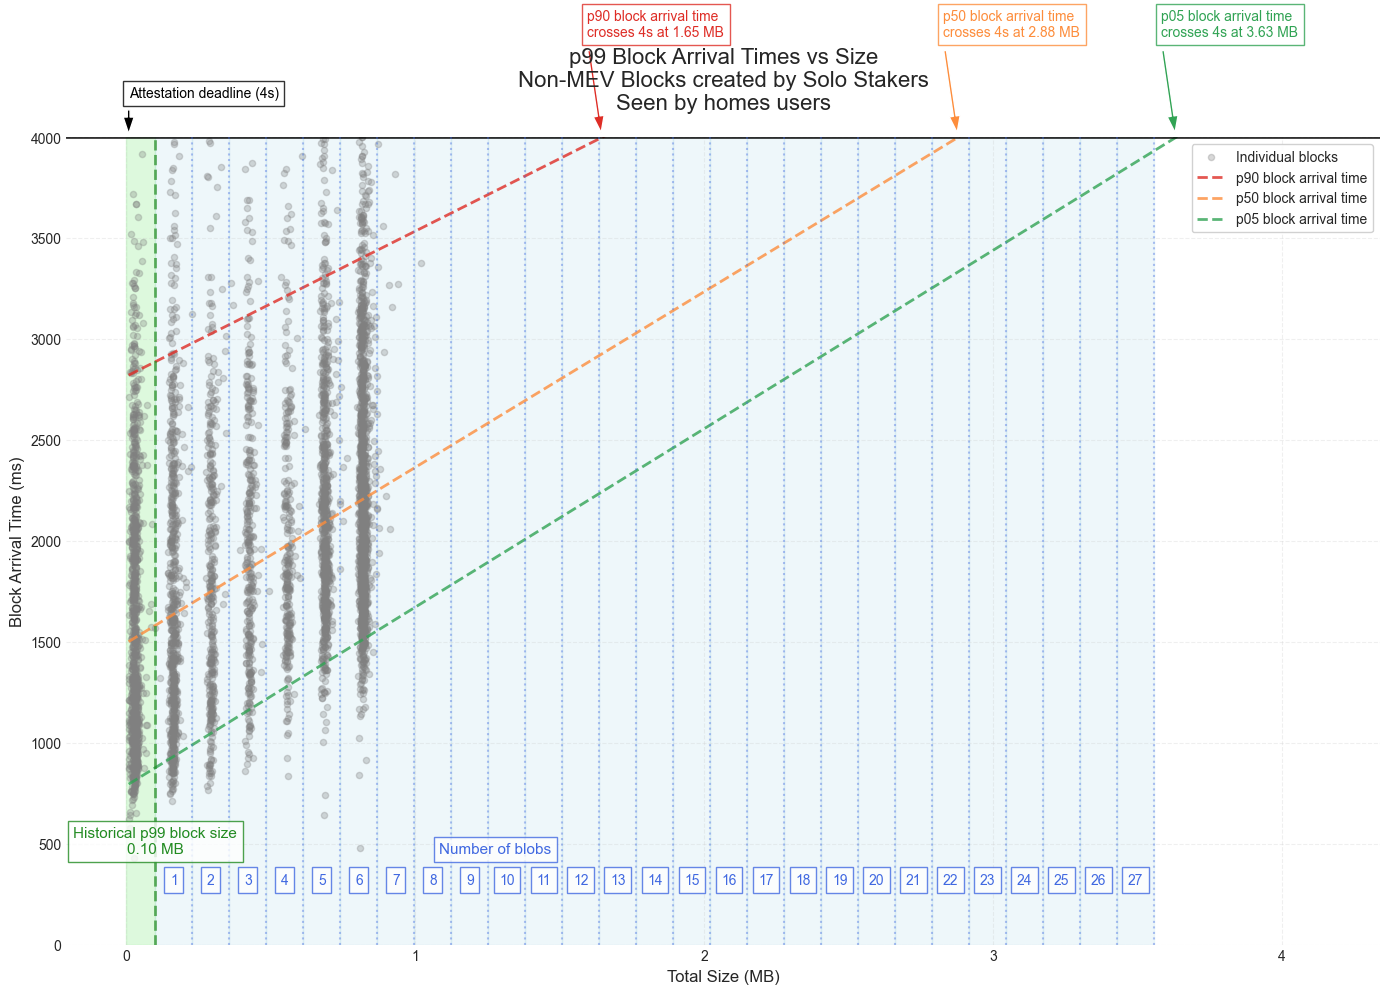

In [202]:
# Calculate p99 block size from data
base_size = combined_data['block_total_bytes_compressed'].quantile(0.99) / 1_000_000  # Convert to MB

# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(non_mev_slots_with_sizes[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'solo_stakers'"))
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Plot scatter points
plt.scatter(plot_data['total_size_mb'], plot_data['p99_arrival_time'], 
           alpha=0.3, s=20, color='gray', label='Individual blocks')

# Add trend lines and annotations
metric = 'p99_arrival_time'
percentiles = [(0.90, '#de2d26', 'p90 block arrival time'), 
              (0.50, '#fd8d3c', 'p50 block arrival time'),
              (0.05, '#31a354', 'p05 block arrival time')]

max_sizes = []
for percentile, color, label in percentiles:
    # Calculate trend line using percentile of p99 arrival times
    size_bins = pd.qcut(plot_data['total_size_mb'], q=20)
    p_per_bin = plot_data.groupby(size_bins)[metric].quantile(percentile)
    bin_centers = size_bins.unique().map(lambda x: x.mid).sort_values()

    # Calculate trend line
    z = np.polyfit(bin_centers, p_per_bin, 1)
    p_fit = np.poly1d(z)

    # Find intersection with 4s deadline
    max_size = (4000 - z[1]) / z[0]
    max_sizes.append(max_size)
    x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)

    # Plot trend line
    plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=label)

    # Add annotation
    plt.annotate(
        f'{label}\ncrosses 4s at {max_size:.2f} MB',
        xy=(max_size, 4000),
        xytext=(max_size-0.05, 4500),
        arrowprops=dict(
            facecolor=color,
            shrink=0.05,
            width=2,
            headwidth=8
        ),
        color=color,
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor=color, alpha=0.8)
    )

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(plot_data['total_size_mb'].min(), 4000),
    xytext=(plot_data['total_size_mb'].min(), 4200),
    arrowprops=dict(
        facecolor='black',
        shrink=0.1,
        width=2,
        headwidth=8
    ),
    color='black',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Add vertical lines and fill areas
blob_increment = 0.128  # 128kb = 0.128 MB

# Fill block size area
plt.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)  # Lighter green
plt.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2)  # Darker green
plt.text(base_size, 450,
         f'Historical p99 block size\n{base_size:.2f} MB',
         color='#228B22',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#228B22', alpha=0.8),
         ha='center')

# Use max_size from p05 (most optimistic case) for blob lines
max_size = max_sizes[2]

# Add lines and fill for each blob increment
for i in range(1, int((max_size - base_size) / blob_increment) + 1):
    x_pos = base_size + (i * blob_increment)
    plt.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
    plt.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
    plt.text(x_pos - blob_increment/2, 300,
             str(i),
             color='#4169E1',
             alpha=1,
             fontsize=10,
             bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
             ha='center')

# Add "blob number" text in the middle
plt.text(base_size + (max_size - base_size)/3, 450,
         'Number of blobs',
         color='#4169E1',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
         ha='center')

# Customize plot
plt.legend(frameon=True, framealpha=0.9, fontsize=10)
plt.title('p99 Block Arrival Times vs Size\nNon-MEV Blocks created by Solo Stakers\nSeen by homes users', 
         pad=20, fontsize=16)
plt.xlabel('Total Size (MB)', fontsize=12)
plt.ylabel('Block Arrival Time (ms)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0, 4000)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate p99 block size from data
base_size = combined_data['block_total_bytes_compressed'].quantile(0.99) / 1_000_000  # Convert to MB

# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(combined_data[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'kiln'"))
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Plot scatter points
plt.scatter(plot_data['total_size_mb'], plot_data['p99_arrival_time'], 
           alpha=0.3, s=20, color='gray', label='Individual blocks')

# Add trend lines and annotations
metric = 'p99_arrival_time'
percentiles = [(0.90, '#de2d26', 'p90 block arrival time'), 
              (0.50, '#fd8d3c', 'p50 block arrival time'),
              (0.05, '#31a354', 'p05 block arrival time')]

max_sizes = []
for percentile, color, label in percentiles:
    # Calculate trend line using percentile of p99 arrival times
    size_bins = pd.qcut(plot_data['total_size_mb'], q=20)
    p_per_bin = plot_data.groupby(size_bins)[metric].quantile(percentile)
    bin_centers = size_bins.unique().map(lambda x: x.mid).sort_values()

    # Calculate trend line
    z = np.polyfit(bin_centers, p_per_bin, 1)
    p_fit = np.poly1d(z)

    # Find intersection with 4s deadline
    max_size = (4000 - z[1]) / z[0]
    max_sizes.append(max_size)
    x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)

    # Plot trend line
    plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=label)

    # Add annotation
    plt.annotate(
        f'{label}\ncrosses 4s at {max_size:.2f} MB',
        xy=(max_size, 4000),
        xytext=(max_size-0.05, 4500),
        arrowprops=dict(
            facecolor=color,
            shrink=0.05,
            width=2,
            headwidth=8
        ),
        color=color,
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor=color, alpha=0.8)
    )

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(plot_data['total_size_mb'].min(), 4000),
    xytext=(plot_data['total_size_mb'].min(), 4200),
    arrowprops=dict(
        facecolor='black',
        shrink=0.1,
        width=2,
        headwidth=8
    ),
    color='black',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Add vertical lines and fill areas
blob_increment = 0.128  # 128kb = 0.128 MB

# Fill block size area
plt.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)  # Lighter green
plt.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2)  # Darker green
plt.text(base_size, 450,
         f'Historical p99 block size\n{base_size:.2f} MB',
         color='#228B22',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#228B22', alpha=0.8),
         ha='center')

# Use max_size from p05 (most optimistic case) for blob lines
max_size = max_sizes[2]

# Add lines and fill for each blob increment
for i in range(1, int((max_size - base_size) / blob_increment) + 1):
    x_pos = base_size + (i * blob_increment)
    plt.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
    plt.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
    plt.text(x_pos - blob_increment/2, 300,
             str(i),
             color='#4169E1',
             alpha=1,
             fontsize=10,
             bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
             ha='center')

# Add "blob number" text in the middle
plt.text(base_size + (max_size - base_size)/3, 450,
         'Number of blobs',
         color='#4169E1',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
         ha='center')

# Customize plot
plt.legend(frameon=True, framealpha=0.9, fontsize=10)
plt.title('p99 Block Arrival Times vs Size\nNon-MEV Blocks created by Kiln\nSeen by homes users', 
         pad=20, fontsize=16)
plt.xlabel('Total Size (MB)', fontsize=12)
plt.ylabel('Block Arrival Time (ms)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0, 4000)
plt.tight_layout()
plt.show()
